C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0032pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0128pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0256pc.fits_DensityData.csv
16
Processing scale: 16
Mass OK
Line Density OK
Length OK
Curvature column found, dtype: object
Curvature sample values: ['0.6472611688293298 rad', '0.6680315894815805 rad', '0.7491577685217812 rad', '0.5686058794529163 rad', '0.6920565835155688 rad']
Extracted 3049 curvature values
Curvature range: 0.33

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

max: 20


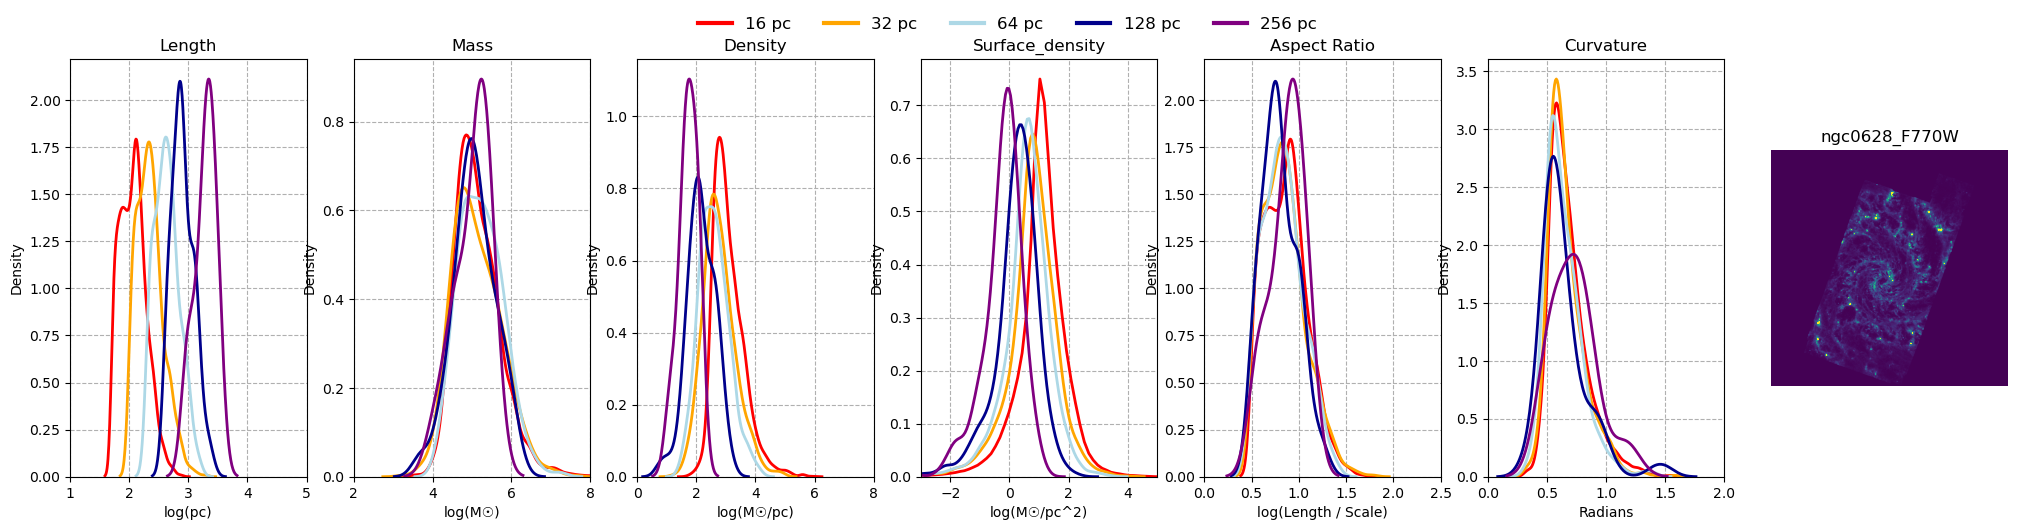

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2500x0 with 0 Axes>

In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import math

# Set consistent scale color mapping
scale_colors = {
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}


def get_min_scale(synthetic_folder):
    min_scale = 500
    for file in os.listdir(synthetic_folder):
        if not file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            print(file_path)
            scale = getScale(file_path)
            if int(scale) < int(min_scale):
                min_scale = scale
    return min_scale

def plot_aspect_ratio(data_dict, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        ratio = data_dict[scale]
        log_ratio = np.log10(ratio[ratio > 0])
        color = scale_colors.get(scale, None)
        sns.kdeplot(log_ratio, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    ax.set_xlabel("log(Length / Scale)")
    ax.set_ylabel("Density")
    ax.set_title("Aspect Ratio")
    ax.set_xlim(0, 2.5)

    ax.grid(True, which="both", ls="--")

def getScale(file):
    scales = ["256", "128", "64", "32", "16"]
    for scale in scales:
        if f"_{scale}" in file or f"{scale}pc" in file:
            return scale
    return None

def plot_quantity(data_dict, quantity_type, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        data = np.array(data_dict[scale])
        
        # Skip if no data
        if len(data) == 0:
            print(f"Warning: No data for {quantity_type} at scale {scale}")
            continue
            
        if quantity_type == "curvature":
            # For curvature, plot the actual values (not log)
            plot_data = data
        else:
            # For other quantities, plot log of positive values
            plot_data = np.log10(data[data > 0])
            
        color = scale_colors.get(scale, None)
        if len(plot_data) > 0:  # Only plot if we have data
            sns.kdeplot(plot_data, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    # Set x-axis labels and limits
    ax.set_xlabel({
        "length": "log(pc)",
        "mass": "log(M☉)",
        "density": "log(M☉/pc)",
        "aspect ratio": "log(AR)",
        "curvature": "Radians",
        "surface_density": "log(M☉/pc^2)"
    }[quantity_type])
    
    ax.set_ylabel("Density")
    ax.set_title(quantity_type.capitalize())
    ax.grid(True, which="both", ls="--")

    # Set appropriate x-axis limits
    xlims = {
        "length": (1, 5),
        "mass": (2, 8),
        "density": (0, 8),
        "curvature": (0, 2),  # More reasonable range for curvature
        "surface_density": (-3,5) 
        }
    if quantity_type in xlims:
        ax.set_xlim(xlims[quantity_type])

        
def plot_galaxy_image(fits_folder, galaxy_name, ax):
    try:
        for file in os.listdir(fits_folder):
            if file.endswith(".fits") and galaxy_name.lower() in file.lower():
                fits_path = os.path.join(fits_folder, file)
                with fits.open(fits_path) as hdul:
                    image_data = hdul[0].data
                    if image_data is not None:
                        image = np.nan_to_num(image_data)

                        # Pad image to square
                        y, x = image.shape
                        size = max(x, y)
                        pad_x = (size - x) // 2
                        pad_y = (size - y) // 2
                        image = np.pad(image, ((pad_y, size - y - pad_y), (pad_x, size - x - pad_x)), 
                                       mode='constant', constant_values=0)

                        vmin, vmax = (0,20) #(np.percentile(image, [1, 99]))
                        print(f'max: { vmax}')
                        ax.imshow(image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
                        ax.set_title(galaxy_name, fontsize=12)
                        ax.axis('off')
                        return
        ax.set_title(f"{galaxy_name} (Image Not Found)", fontsize=10)
        ax.axis('off')
    except Exception:
        ax.set_title(f"{galaxy_name} (Error)", fontsize=10)
        ax.axis('off')

# Base paths
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
fits_folder = base_dir / "OriginalImages"
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)

# Filter valid galaxy folders
galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder)
    and folder not in ['Figures', 'OriginalImages', 'IC5146_PSW', 'masks_v5_simple']
    and not folder.endswith('.txt') and not folder.endswith('.xlsx')
]

# Load data for valid galaxies
valid_galaxies = []
galaxy_data = {}



for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'

    mass_dict = {}
    length_dict = {}
    density_dict = {}
    aspect_ratio_dict = {}
    curvature_dict = {}
    mass_surface = {}

    min_scale = get_min_scale(synthetic_folder)
    for file in os.listdir(synthetic_folder):
        if not file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            if file.endswith(".xlsx"):
                df = pd.read_excel(file_path, engine='openpyxl')
            elif file.endswith(".xls"):
                df = pd.read_excel(file_path)
            elif file.endswith(".csv"):
                df = pd.read_csv(file_path)
            else:
                continue

            scale = getScale(file_path)
            print(scale)
            if scale is None:
                continue

            try:
                print(f"Processing scale: {scale}")
                mass = df[f'Mass_{scale}.0']
                print("Mass OK")

                Line_Density = df[f'Line_Density_{scale}.0'] * (int(min_scale)/int(scale))
                print("Line Density OK")

                lengths = df[f'Length_{scale}.0'] * (int(scale)/int(min_scale))
                print("Length OK")

                mass_dict[scale] = np.array(mass)
                length_dict[scale] = np.array(lengths)
                density_dict[scale] = np.array(Line_Density)
                aspect_ratio_dict[scale] = np.array(lengths) / float(scale)
                
                # DEBUG: Check if curvature column exists
                curvature_col_name = f'Curvature_{scale}.0'
                if curvature_col_name not in df.columns:
                    print(f"ERROR: Column '{curvature_col_name}' not found in dataframe!")
                    print(f"Available columns: {[col for col in df.columns if scale in col]}")
                    continue
                
                curvature = df[curvature_col_name]
                print(f"Curvature column found, dtype: {curvature.dtype}")
                print(f"Curvature sample values: {curvature.head().tolist()}")
                
                # Handle different data types and missing values properly
                curvature_values = []
                for i, s in enumerate(curvature):
                    if pd.isna(s):
                        #print(f"NaN at index {i}")
                        continue
                    try:
                        # Handle if it's already a number
                        if isinstance(s, (int, float, np.number)):
                            curvature_values.append(float(s))
                        # Handle if it's a string with units (e.g., "1.23 rad")
                        elif isinstance(s, str):
                            # Extract numeric part before any space
                            numeric_part = s.split()[0]
                            curvature_values.append(float(numeric_part))
                        else:
                            print(f"Unexpected type at index {i}: {type(s)} - {s}")
                    except (ValueError, AttributeError) as e:
                        print(f"Error processing index {i}: {s} - {e}")
                        continue
                
                print(f"Extracted {len(curvature_values)} curvature values")
                if curvature_values:
                    print(f"Curvature range: {min(curvature_values):.3f} to {max(curvature_values):.3f}")
                
                curvature_dict[scale] = np.array(curvature_values)

            except (KeyError, ValueError) as e:
                print(f"ERROR!!! {type(e).__name__}: {e}")
                print(f"Error occurred at scale: {scale}")
                continue

            try:
                surface_density_path = base_dir / folder / 'Molecular_Mass'
                for fname in os.listdir(surface_density_path):
                    file = os.path.join(surface_density_path, fname)

                    # Skip non-FITS
                    if not file.lower().endswith(('.fits', '.fit', '.fz')) or not os.path.isfile(file):
                        print(f"Skipping: {file}")
                        continue

                    try:
                        scale = getScale(file)

                        with fits.open(file, ignore_missing=True) as hdul:
                            if hdul[0].data is None:
                                print(f"No data in primary HDU for {file}")
                                continue
                            OrigData = np.array(hdul[0].data)

                        surface_density_data = np.array(OrigData.flatten()) / (5.24**2)  # 1 px = 5.24 pc^2
                        surface_density_data = np.array(surface_density_data[surface_density_data != 0])

                        Npix = 1.13 * (16 / 5.24) ** 2 * int(scale) / 16
                        mass_surface[scale] = np.array(surface_density_data) / Npix

                        print(f"✅ {file} → median = {np.median(surface_density_data / Npix)}")

                    except Exception as e:
                        print(f"❌ Error processing {file}: {e}")
                        continue

            except Exception as e:
                print(f"❌ Could not find molecular mass data: {e}")

        file
    if length_dict:
        valid_galaxies.append(galaxy_name)
        galaxy_data[galaxy_name] = {
            "mass": mass_dict,
            "length": length_dict,
            "density": density_dict,
            "aspect": aspect_ratio_dict,
            "curvature": curvature_dict,
            "surface_density": mass_surface
        }

# Function to plot subset of galaxies and save figure
def plot_galaxies_subset(galaxy_subset, filename):
    num = len(galaxy_subset)
    fig = plt.figure(figsize=(25, 4.8 * num))
    gs = gridspec.GridSpec(num, 7, figure=fig)

    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]
        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])
        ax3 = fig.add_subplot(gs[i, 2])
        ax4 = fig.add_subplot(gs[i, 3])
        ax5 = fig.add_subplot(gs[i, 4])
        ax6 = fig.add_subplot(gs[i, 5])
        ax7 = fig.add_subplot(gs[i, 6])

        plot_quantity(data["length"], "length", ax1)
        plot_quantity(data["mass"], "mass", ax2)
        plot_quantity(data["density"], "density", ax3)
        plot_quantity(data["surface_density"], "surface_density", ax4)
        plot_aspect_ratio(data["aspect"], ax5)
        plot_quantity(data["curvature"], "curvature", ax6)
        plot_galaxy_image(fits_folder, galaxy, ax7)

        ax1.set_ylabel("Density")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=color, lw=3)
        for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
    ]
    fig.legend(handles=legend_elements,
               labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
               loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=len(scale_colors), fontsize=12, frameon=False)

    plt.subplots_adjust(top=0.98, hspace=0.35)

    output_path = output_folder / filename
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    fig.savefig(output_folder / (filename.replace('.png', '.pdf')), format='pdf', bbox_inches='tight')
    plt.show()

# Save all galaxies figure
# plot_galaxies_subset(valid_galaxies, "AllGalaxies_Summary.png")

# # Save first 9 galaxies figure
# plot_galaxies_subset(valid_galaxies[:9], "First9Galaxies_Summary.png")

# # Save last 9 galaxies figure
# plot_galaxies_subset(valid_galaxies[-9:], "Last9Galaxies_Summary.png")

# # Save first 9 galaxies figure
plot_galaxies_subset(valid_galaxies[:5], "First6Galaxies_Summary.png")

plot_galaxies_subset(valid_galaxies[5:10], "Middle6Galaxies_Summary.png")

# # Save last 9 galaxies figure
plot_galaxies_subset(valid_galaxies[-5:], "Last6Galaxies_Summary.png")


from collections import defaultdict
import numpy as np

# Define the scales and initialize the master dict
scales = ['8', "16", "32", "64", "128", "256"]
quantities = ["mass", "length", "density", "surface_density", "curvature", "aspect"]
master_dict = {q: {scale: [] for scale in scales} for q in quantities}

# Combine data across all galaxies
for galaxy in valid_galaxies:
    mass_data = galaxy_data[galaxy]["mass"]
    length_data = galaxy_data[galaxy]["length"]
    density_data = galaxy_data[galaxy]["density"]
    aspect_data = galaxy_data[galaxy]["aspect"]
    curvature_data = galaxy_data[galaxy]["curvature"]
    surface_density_data = galaxy_data[galaxy]["surface_density"]
    for scale in scales:
        try:
            master_dict["mass"][scale].append(mass_data[scale])
            master_dict["length"][scale].append(length_data[scale])
            master_dict["density"][scale].append(density_data[scale])
            master_dict["aspect"][scale].append(aspect_data[scale])
            master_dict["curvature"][scale].append(curvature_data[scale])
            master_dict["surface_density"][scale].append(surface_density_data[scale])

        except KeyError:
            # Skip if this galaxy doesn't have data for this scale
            continue

# Convert lists of arrays into flat numpy arrays
for quantity in master_dict:
    for scale in master_dict[quantity]:
        if master_dict[quantity][scale]:  # Avoid empty lists
            master_dict[quantity][scale] = np.concatenate(master_dict[quantity][scale])
        else:
            master_dict[quantity][scale] = np.array([])  # fallback for missing data
fig, axes = plt.subplots(1, 5, figsize=(24, 6))

plot_quantity(master_dict["length"], "length", axes[0])
plot_quantity(master_dict["mass"], "mass", axes[1])
plot_quantity(master_dict["density"], "density", axes[2])
plot_quantity(master_dict["surface_density"], "surface_density", axes[3])
plot_aspect_ratio(master_dict["aspect"], axes[4])
plot_quantity(master_dict["curvature"], "curvature", axes[5])  # <-- was axes[3]


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color, lw=3)
    for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
]
fig.legend(
    handles=legend_elements,
    labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=len(scale_colors), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Combined Distribution Across All Galaxies", fontsize=16)

# Save the plot
final_combined_path = output_folder / "AllGalaxies_Combined_Corrected.png"
fig.savefig(final_combined_path, dpi=300, bbox_inches='tight')
fig.savefig(final_combined_path.with_suffix(".pdf"), format='pdf', bbox_inches='tight')
plt.show()



ngc0628_F2100W
ngc0628_F770W
ngc1087_F770W
ngc1300_F770W
ngc1385_F770W
ngc1433_F770W
ngc1512_F770W
ngc1566_F770W
ngc2090_F555W
ngc2835_F770W
ngc3351_F770W
ngc3627_F770W
ngc4254_F770W
ngc4303_F770W
ngc4321_F770W
ngc4535_F770W
ngc5068_F770W
ngc7496_F770W
Total galaxies found: 16
   → Plotting ngc0628_F770W


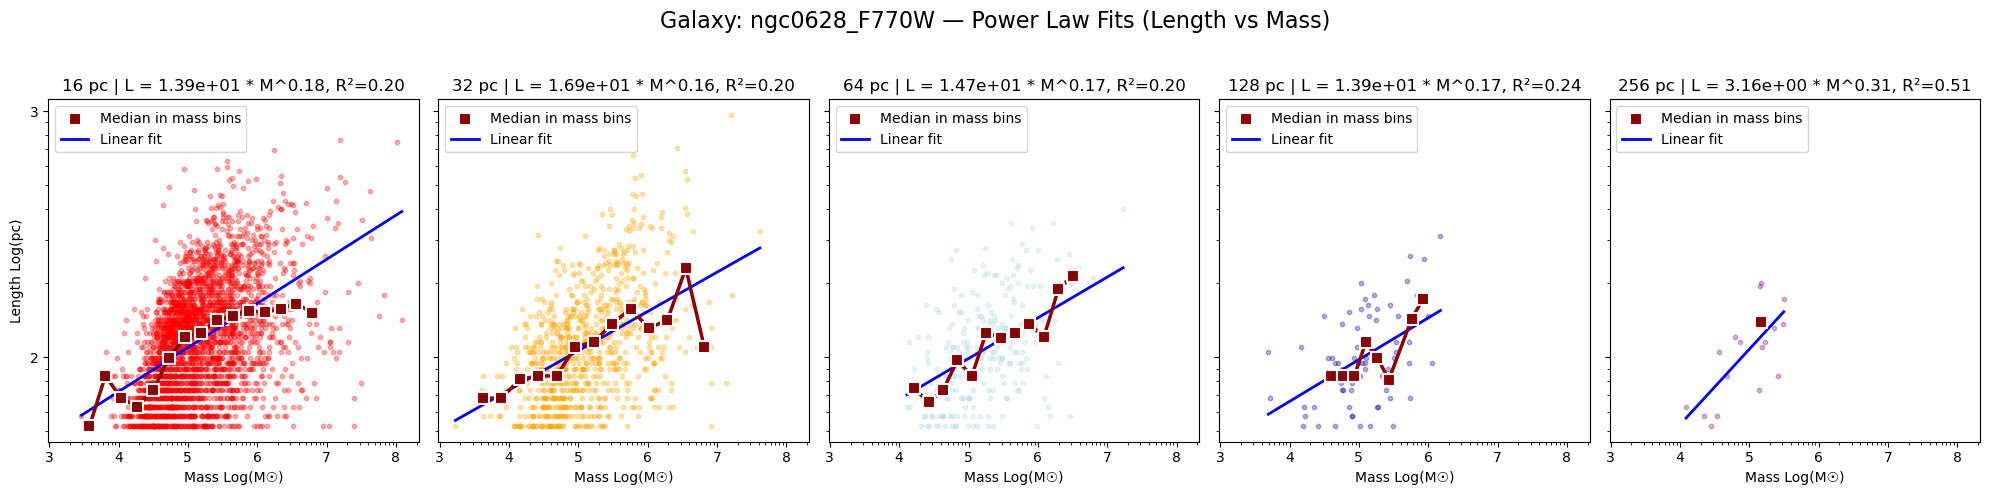

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc0628_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc1087_F770W


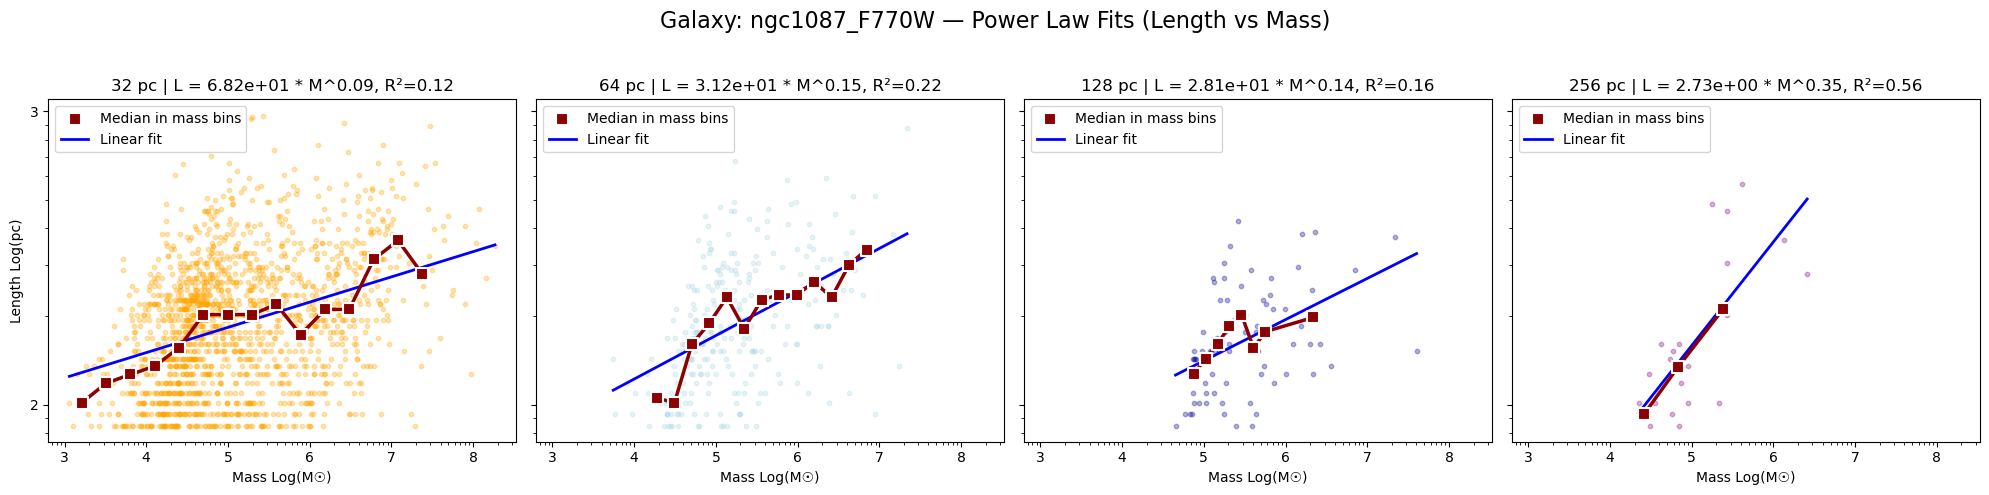

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc1087_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc1300_F770W


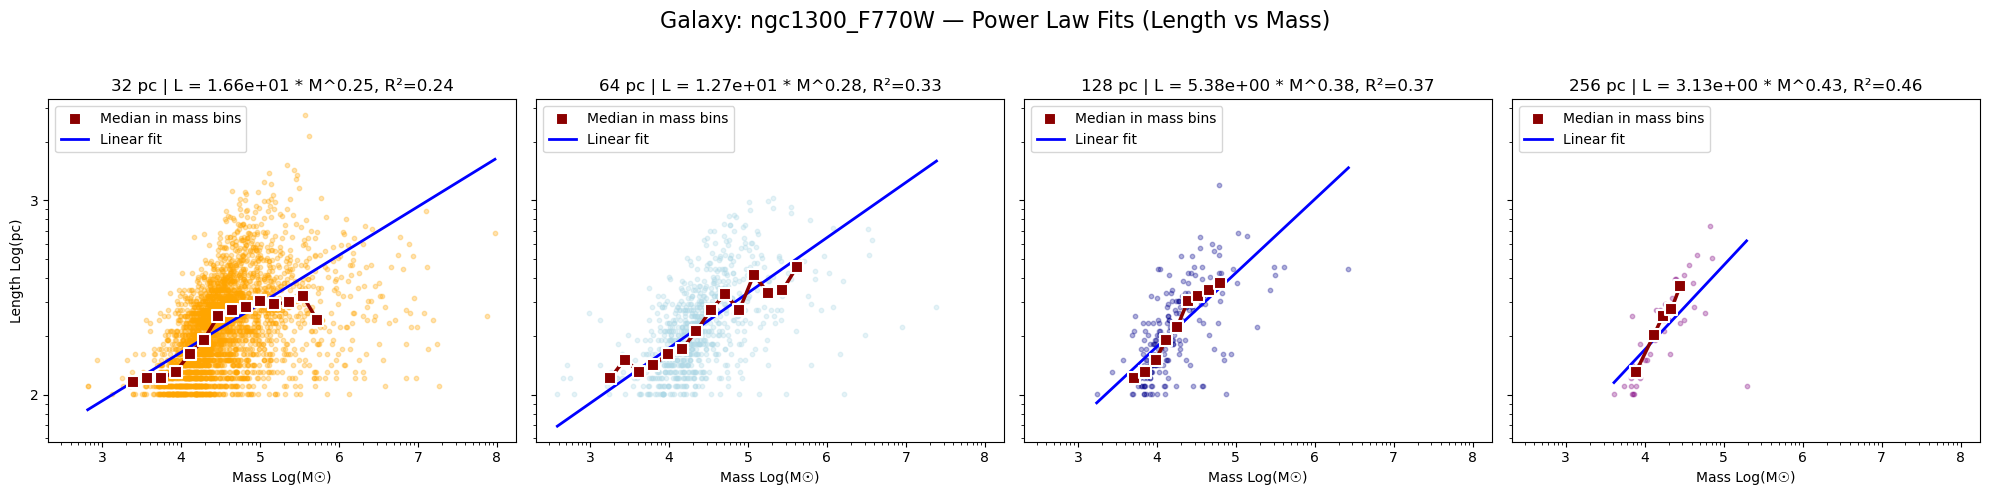

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc1300_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc1385_F770W


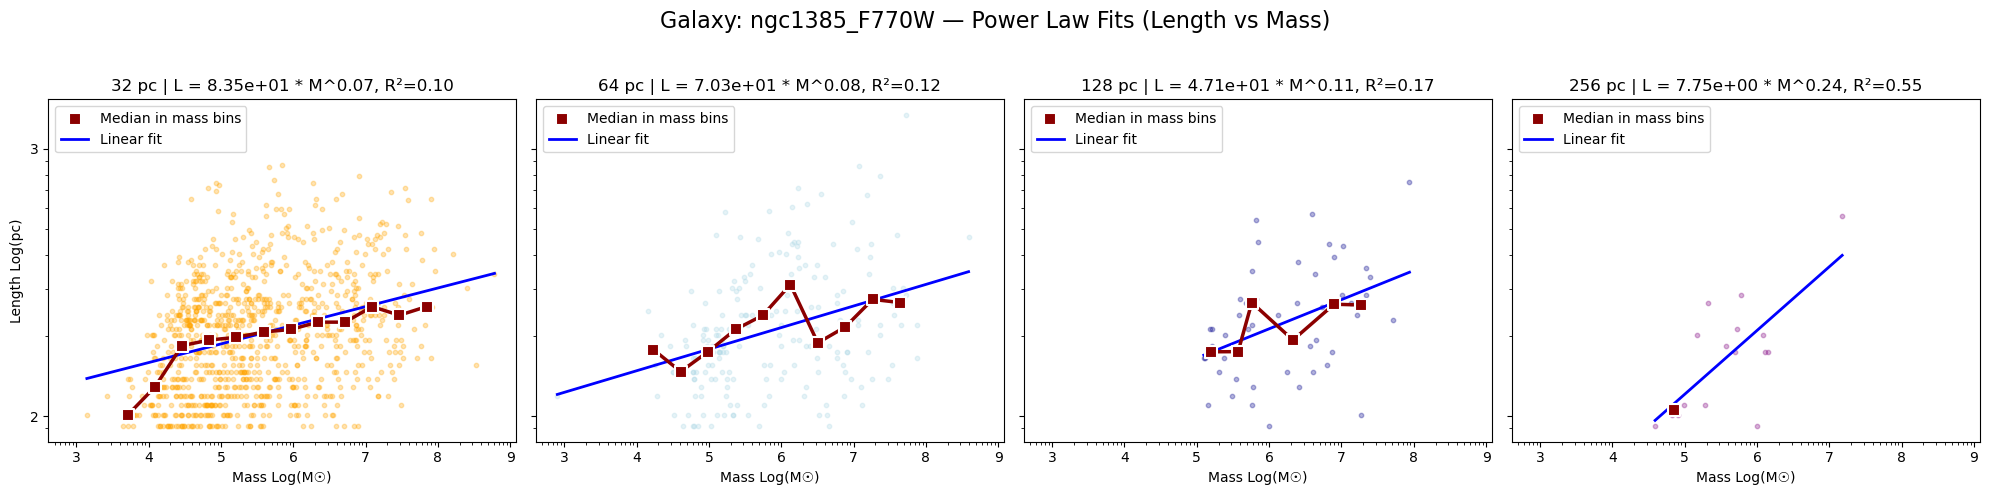

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc1385_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc1433_F770W


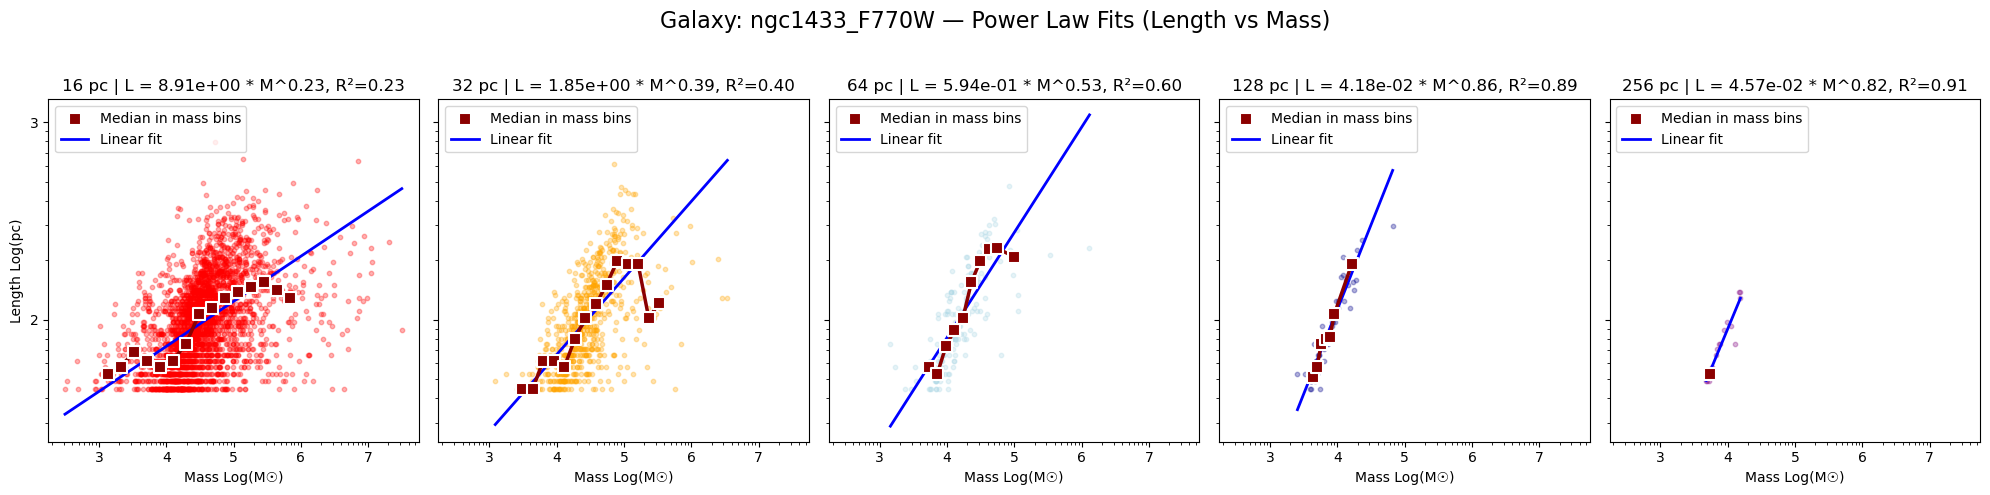

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc1433_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc1512_F770W


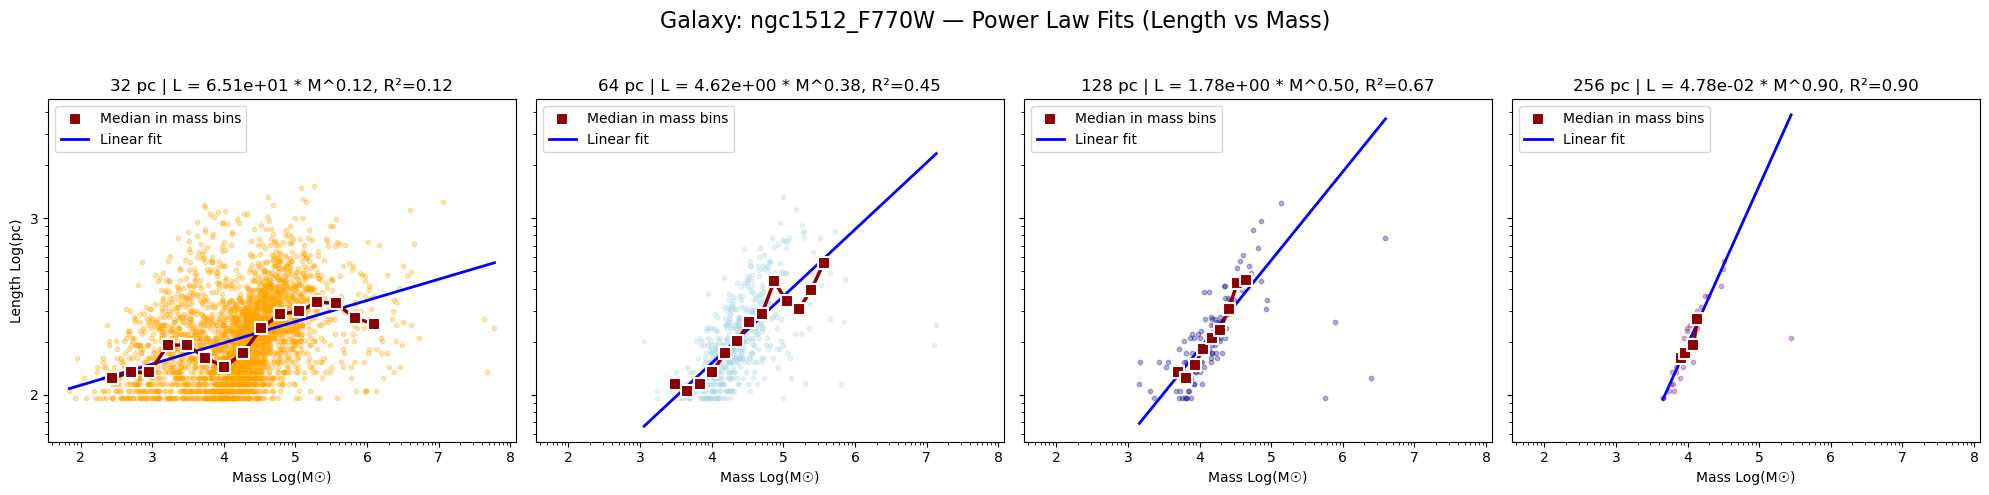

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc1512_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc1566_F770W


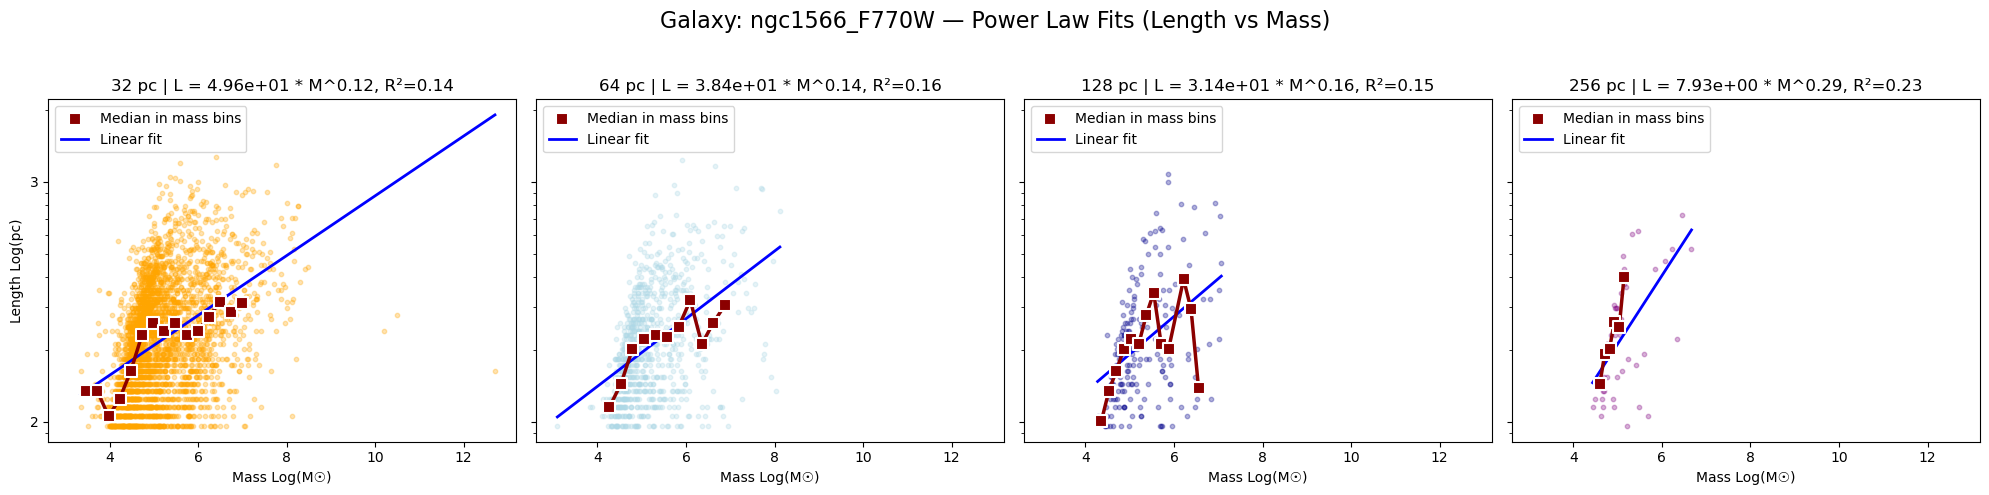

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc1566_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc2835_F770W


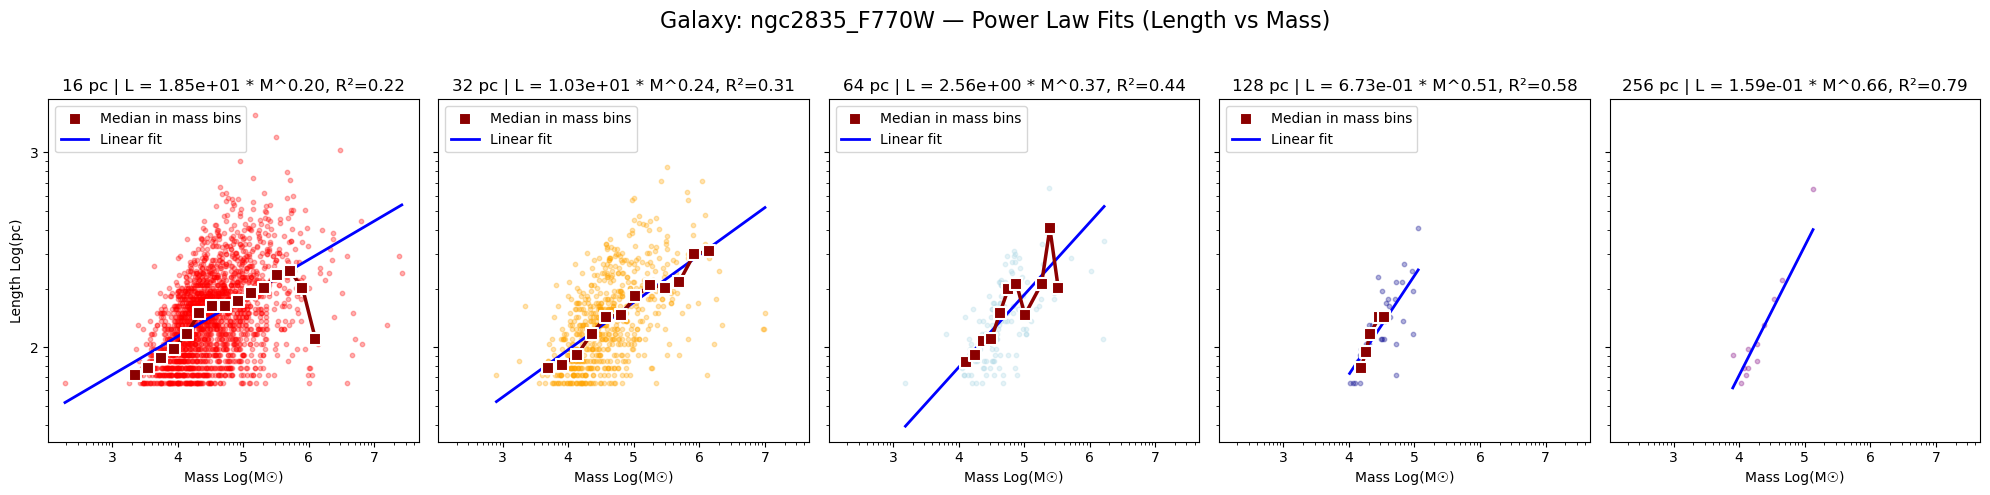

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc2835_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc3351_F770W


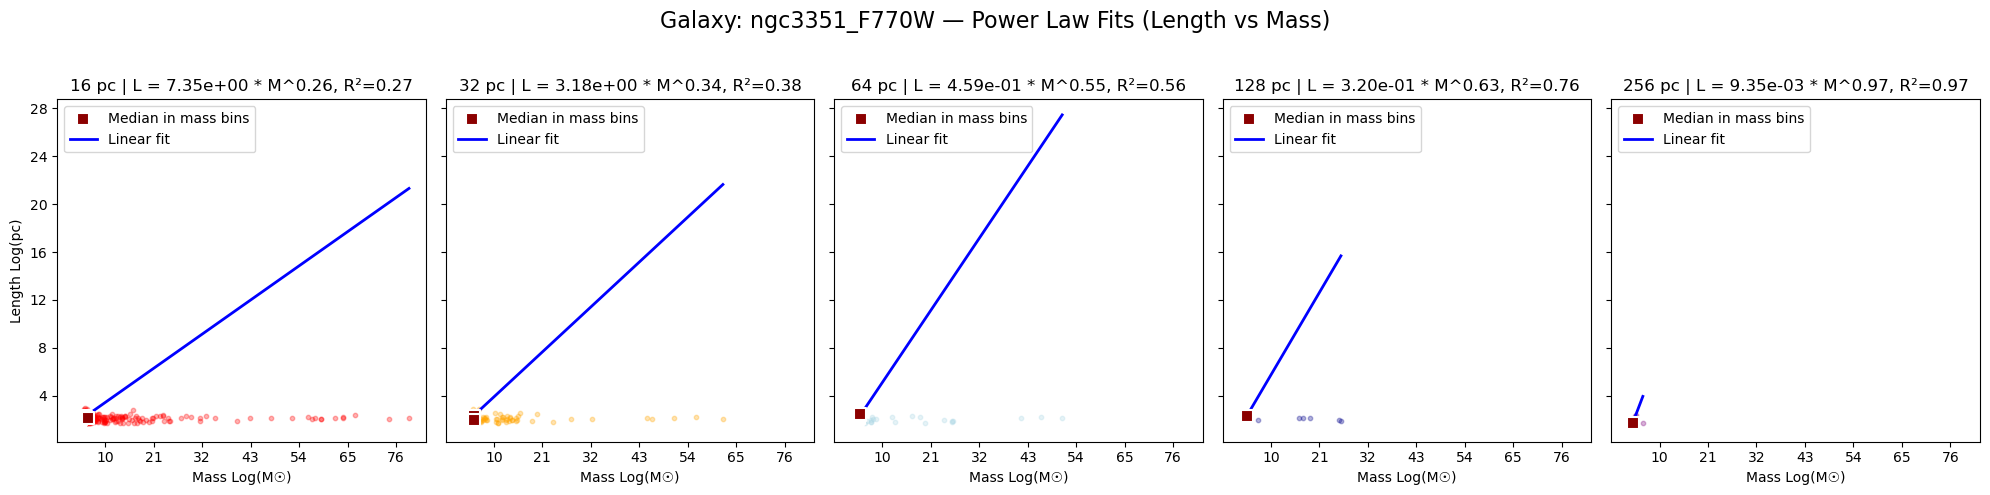

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc3351_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc3627_F770W


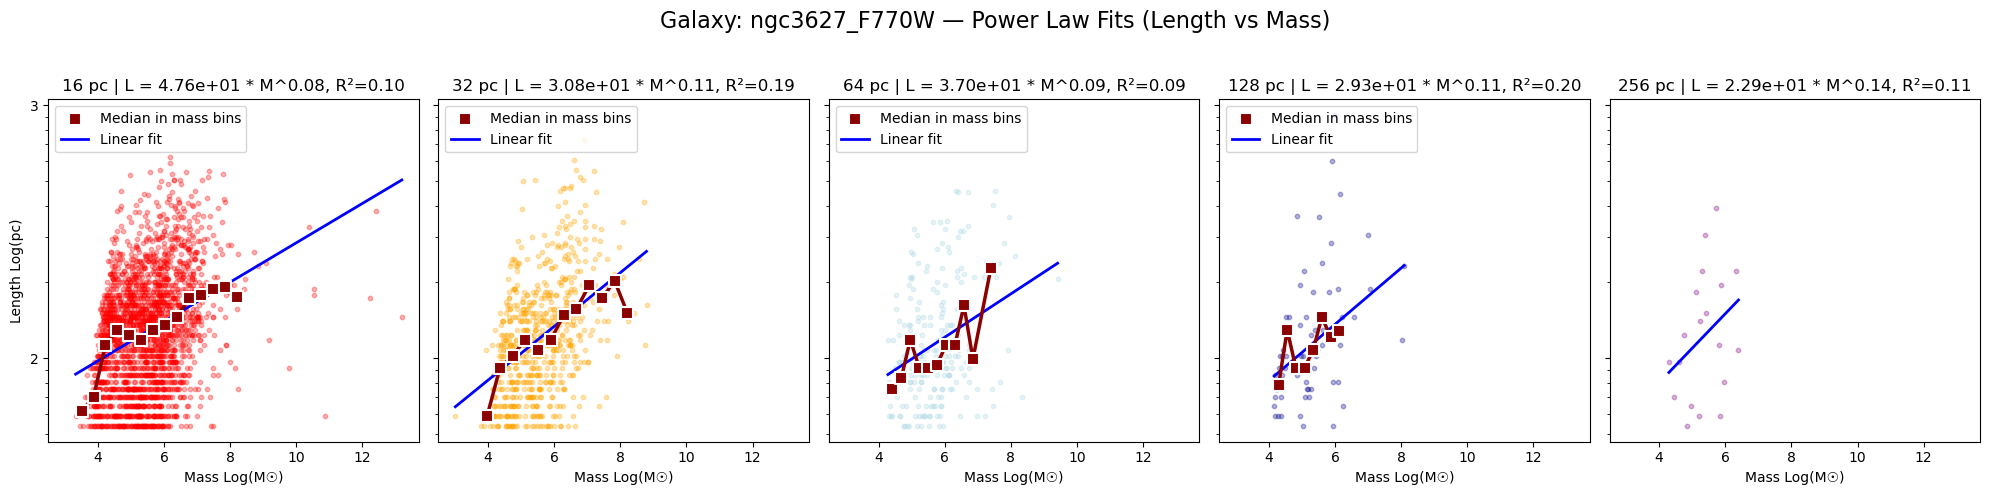

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc3627_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc4254_F770W


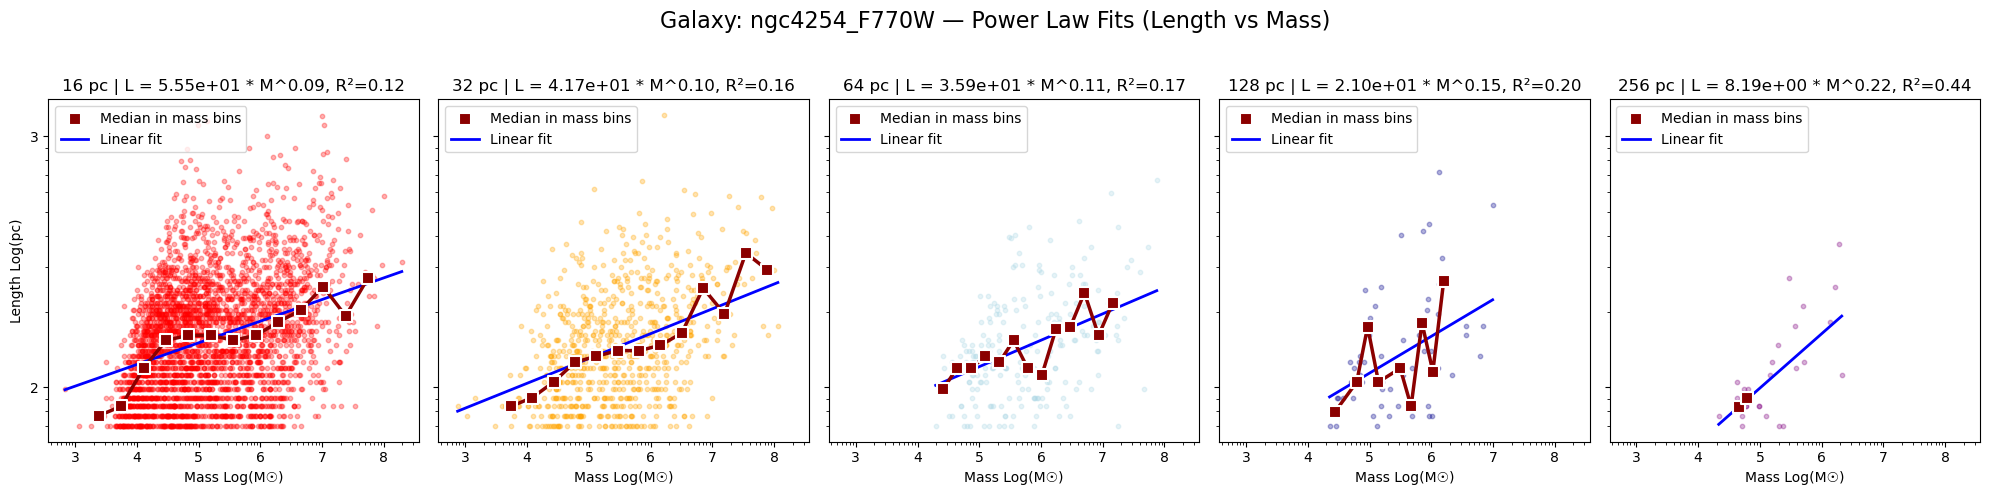

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc4254_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc4303_F770W


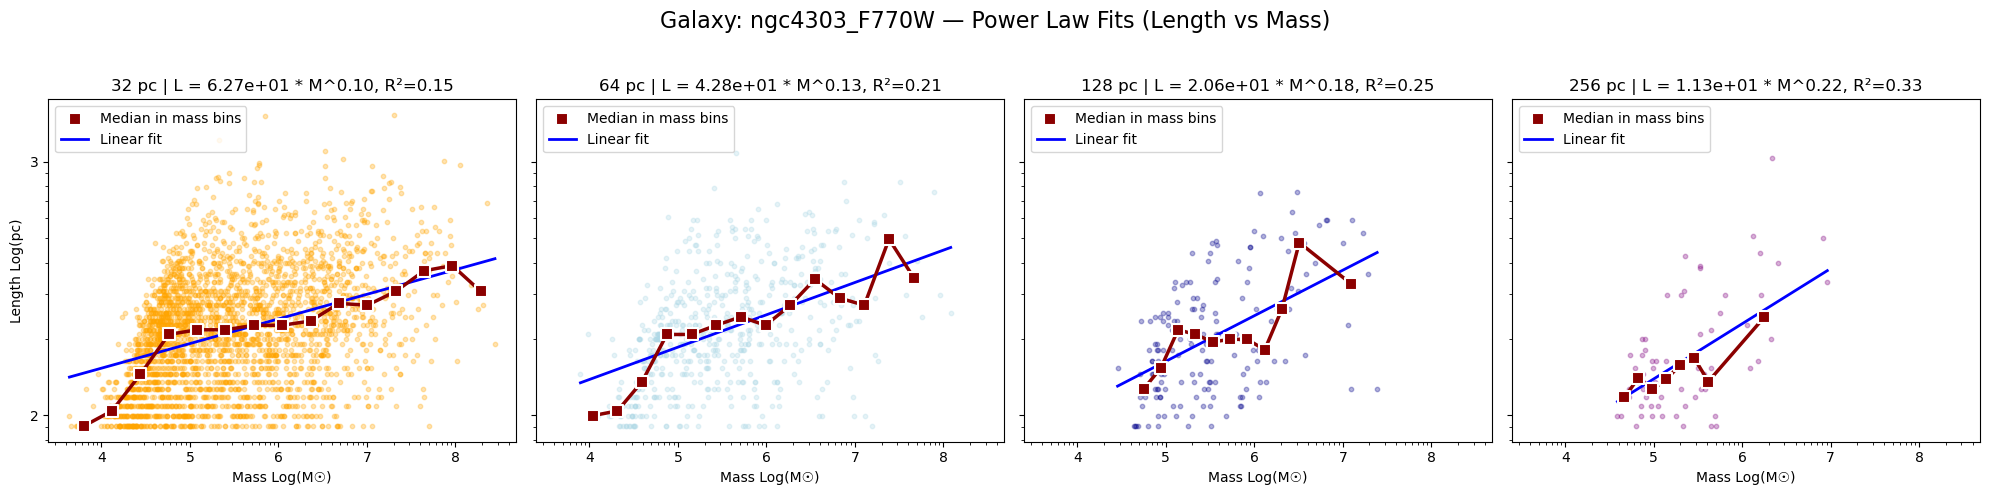

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc4303_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc4321_F770W


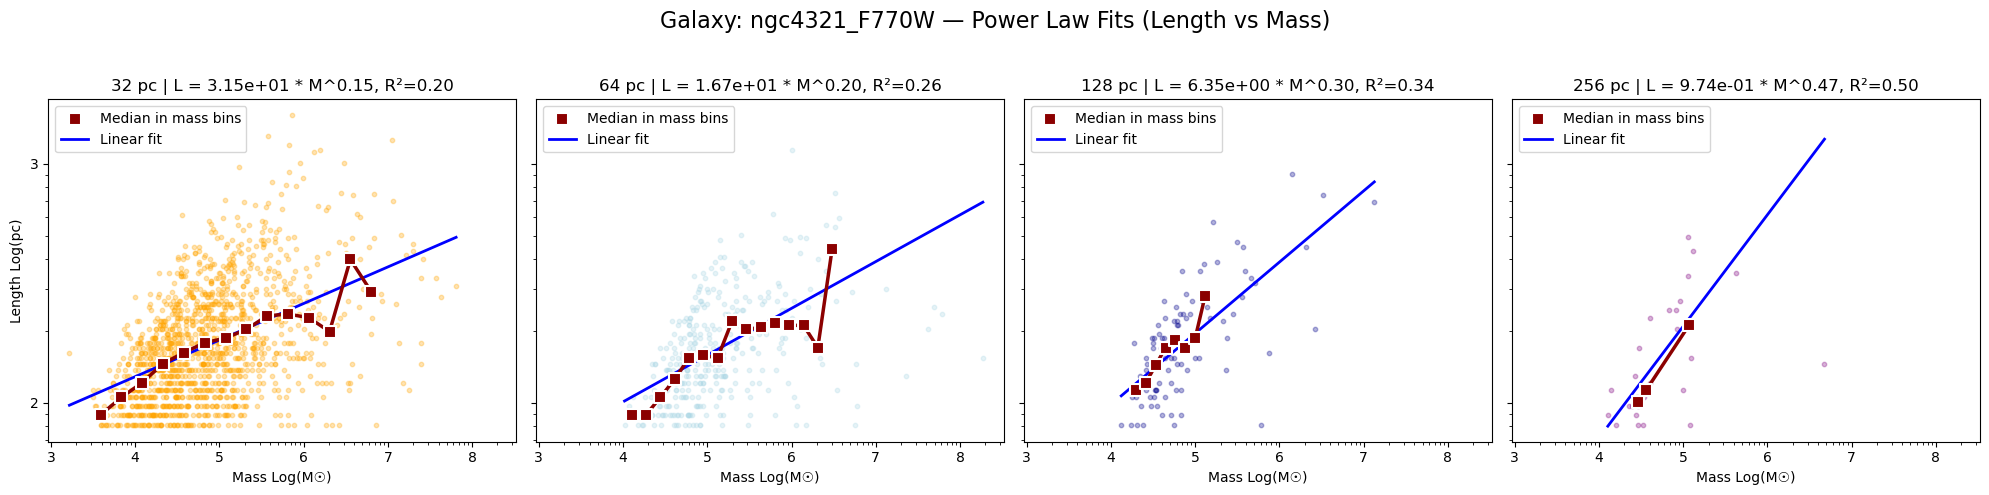

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc4321_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc4535_F770W


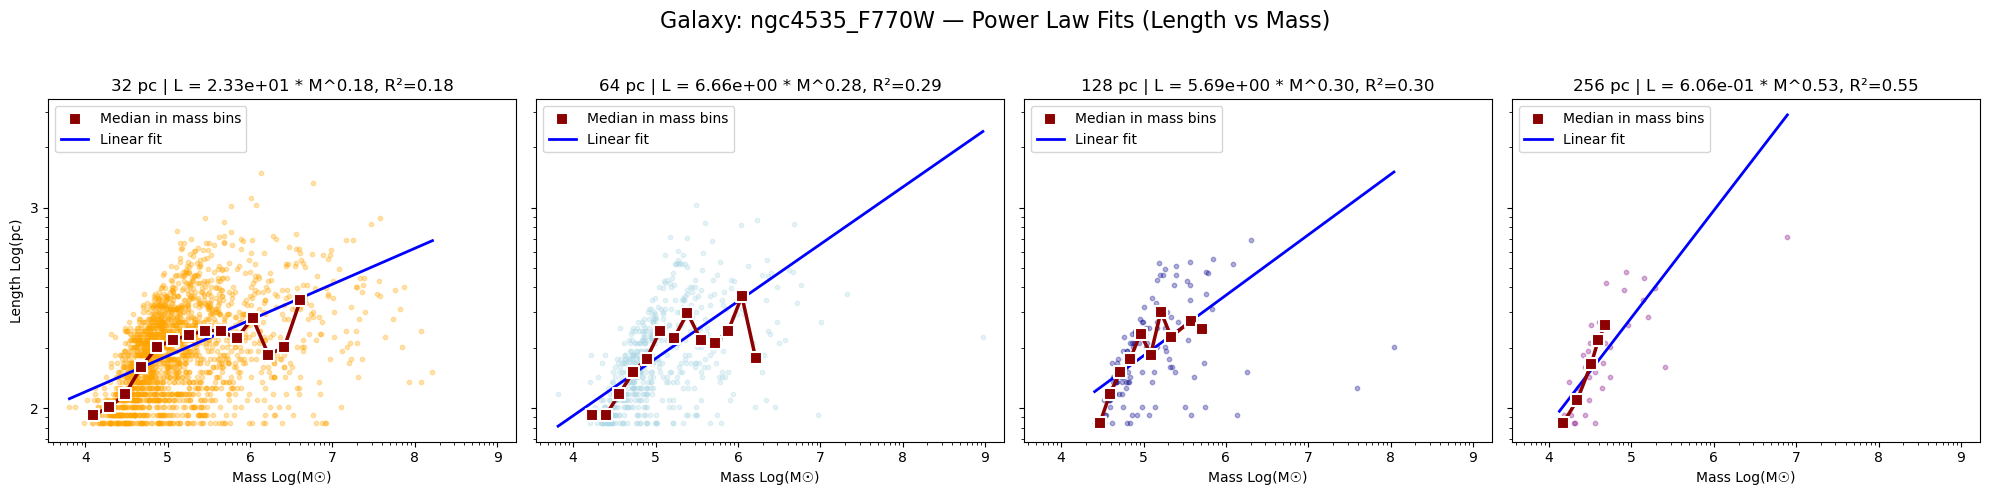

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc4535_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc5068_F770W


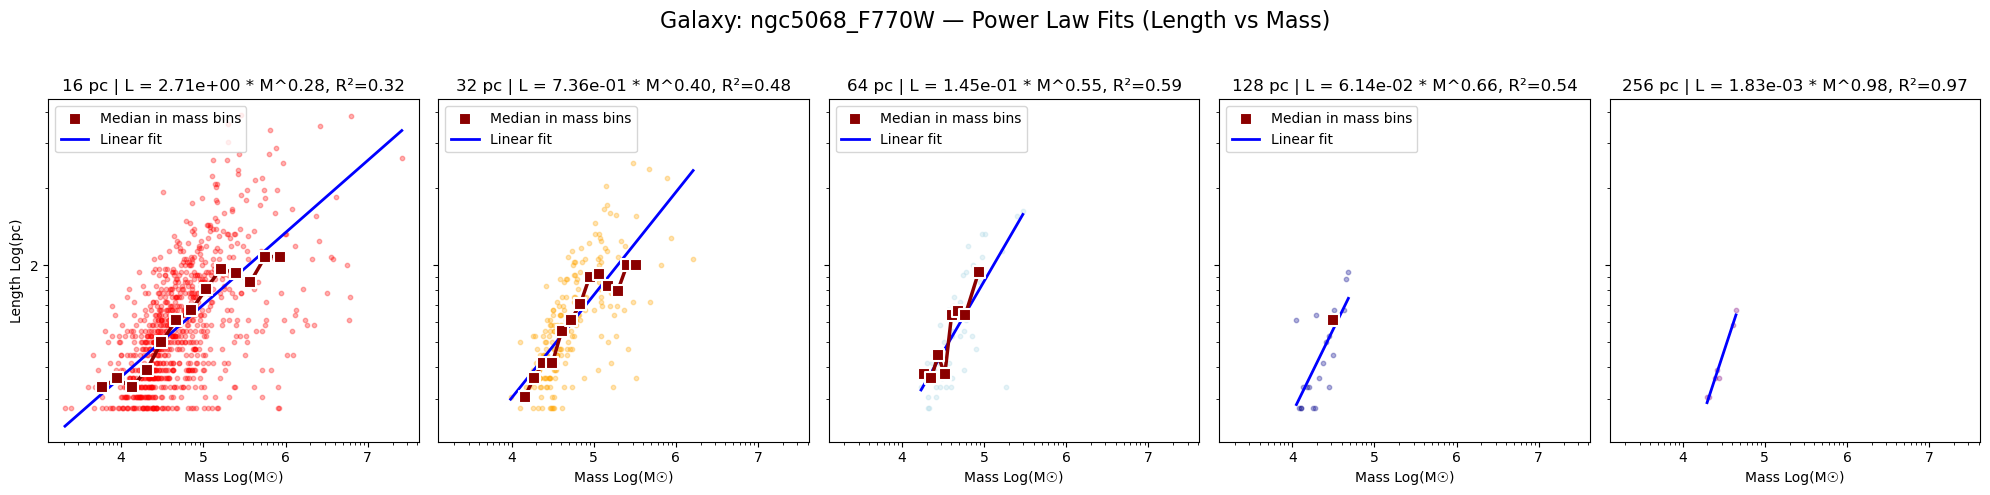

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc5068_F770W_Length_vs_Mass_PowerLaw.png
   → Plotting ngc7496_F770W


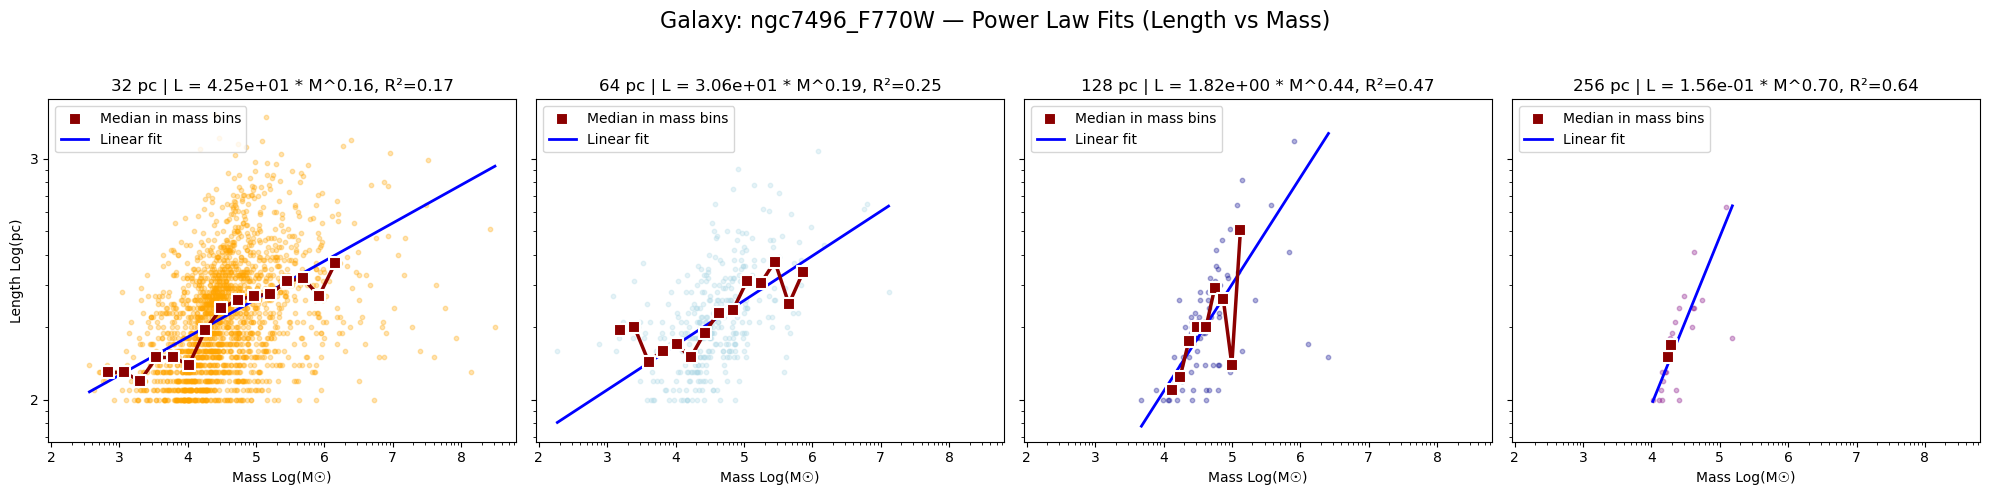

   ✔ Saved: C:\Users\jhoffm72\Documents\FilPHANGS\Data\Figures\ngc7496_F770W_Length_vs_Mass_PowerLaw.png
✅ All galaxies processed


In [33]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker

# ----------------------------
# Color scheme for scales
# ----------------------------
scale_colors = {
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}

# ----------------------------
# Helper to detect scale from filename
# ----------------------------
def getScale(file):
    scales = ["256", "128", "64", "32", "16"]
    for scale in scales:
        if f"_{scale}" in file or f"{scale}pc" in file:
            return scale
    return None

# ----------------------------
# Robust outlier removal
# ----------------------------
def remove_outliers(x, y, thresh=3.5):
    def filter_arr(arr):
        med = np.median(arr)
        mad = np.median(np.abs(arr - med))
        if mad == 0:
            return np.ones_like(arr, dtype=bool)
        z = 0.6745 * (arr - med) / mad
        return np.abs(z) < thresh
    mask_x = filter_arr(x)
    mask_y = filter_arr(y)
    return x[mask_x & mask_y], y[mask_x & mask_y]

# ----------------------------
# Custom formatter for log axes (shows only exponents)
# ----------------------------
class ExponentFormatter(ticker.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        coeff = x / (10 ** exponent)
        
        # Only show the exponent, not the full scientific notation
        return f'{exponent}'

# ----------------------------
# Function to calculate median values in bins (in log-log space)
# ----------------------------
def calculate_median_bins_loglog(logx, logy, num_bins=15):
    # Create bins that are uniformly spaced in log space
    bins_log = np.linspace(logx.min(), logx.max(), num_bins + 1)
    
    bin_centers_log = []
    median_values_log = []
    
    for i in range(num_bins):
        mask = (logx >= bins_log[i]) & (logx < bins_log[i+1])
        if np.sum(mask) > 3:  # Require at least 4 points in bin
            # Use arithmetic mean for bin center in log space
            bin_center_log = (bins_log[i] + bins_log[i+1]) / 2
            median_val_log = np.median(logy[mask])
            bin_centers_log.append(bin_center_log)
            median_values_log.append(median_val_log)
    
    # Convert back to linear space for plotting
    bin_centers_linear = 10**np.array(bin_centers_log)
    median_values_linear = 10**np.array(median_values_log)
    
    return bin_centers_linear, median_values_linear

# ----------------------------
# Function to plot Length vs Mass (Power law in log-log space)
# ----------------------------
def plot_length_vs_mass_powerlaw(galaxy_name, data_dict, output_path):
    print(f"   → Plotting {galaxy_name}")

    fig, axes = plt.subplots(1, len(data_dict["length"]), figsize=(20, 5), sharey=True, sharex=True)

    if len(data_dict["length"]) == 1:
        axes = [axes]

    for ax, (scale, lengths) in zip(axes, sorted(data_dict["length"].items(), key=lambda x: float(x[0]))):
        if scale not in data_dict["mass"]:
            continue
        masses = np.array(data_dict["mass"][scale])
        lengths = np.array(lengths)

        mask = (masses > 0) & (lengths > 0)
        if not np.any(mask):
            ax.set_title(f"{scale} pc (No Data)")
            continue

        x = masses[mask]
        y = lengths[mask]

        # Transform to log space
        logx, logy = np.log10(x), np.log10(y)

        # Outlier removal in log space
        logx, logy = remove_outliers(logx, logy)
        if len(logx) < 5:
            ax.set_title(f"{scale} pc (Too few points)")
            continue

        # Scatter plot (transparent points)
        ax.scatter(x, y, color=scale_colors.get(scale, "black"), alpha=0.3, s=10)
        
        # Calculate and plot median values in bins (in log-log space)
        bin_centers, median_values = calculate_median_bins_loglog(logx, logy, num_bins=15)
        if len(bin_centers) > 0:
            ax.scatter(bin_centers, median_values, color='darkred', s=80, marker='s', 
                      edgecolors='white', linewidth=1.5, label='Median in mass bins', zorder=5)
            # Connect median points with lines
            ax.plot(bin_centers, median_values, color='darkred', linestyle='-', linewidth=2.5, zorder=4)

        # Fit line in log-log space
        model = LinearRegression()
        model.fit(logx.reshape(-1, 1), logy)
        slope = model.coef_[0]
        intercept = model.intercept_

        # Predictions & R²
        logy_pred = model.predict(logx.reshape(-1, 1))
        r2 = r2_score(logy, logy_pred)

        # Smooth fit line
        x_line = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
        y_line = 10**(intercept + slope * np.log10(x_line))
        ax.plot(x_line, y_line, color="blue", lw=2, label='Linear fit')

        # Equation + R² in title
        A = 10**intercept
        ax.set_title(f"{scale} pc | L = {A:.2e} * M^{slope:.2f}, R²={r2:.2f}")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Mass Log(M☉)")
        
        # Apply custom formatter to show only exponents
        ax.xaxis.set_major_formatter(ExponentFormatter())
        ax.yaxis.set_major_formatter(ExponentFormatter())
        
        # Add legend if we have median points
        if len(bin_centers) > 0:
            ax.legend(loc='upper left')

    axes[0].set_ylabel("Length Log(pc)")
    fig.suptitle(f"Galaxy: {galaxy_name} — Power Law Fits (Length vs Mass)", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Save
    save_path = output_path / f"{galaxy_name}_Length_vs_Mass_PowerLaw.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

    print(f"   ✔ Saved: {save_path}")


# ----------------------------
# Load data
# ----------------------------
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)

galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder)
    and folder not in ['Figures', 'OriginalImages', 'IC5146_PSW']
    and not folder.endswith('.txt') and not folder.endswith('.xlsx')
]

galaxy_data = {}

for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'

    if not synthetic_folder.exists():
        continue

    mass_dict, length_dict = {}, {}

    for file in os.listdir(synthetic_folder):
        file_path = synthetic_folder / file
        try:
            if file.endswith(".xlsx"):
                df = pd.read_excel(file_path, engine="openpyxl")
            elif file.endswith(".xls"):
                df = pd.read_excel(file_path)
            elif file.endswith(".csv"):
                df = pd.read_csv(file_path)
            else:
                continue
        except Exception as e:
            print(f"   ⚠ Skipping {file_path} ({e})")
            continue

        scale = getScale(file)
        if scale is None:
            continue

        try:
            mass = df[f"Mass_{scale}.0"]
            length = df[f"Length_{scale}.0"]


            mass_dict[scale] = np.array(mass)
            length_dict[scale] = np.array(length)
        except KeyError:
            mass = df[f"Mass_{scale}"]
            length = df[f"Length_{scale}"]
            mass_dict[scale] = np.array(mass)
            length_dict[scale] = np.array(length)

    if length_dict and mass_dict:
        galaxy_data[galaxy_name] = {"mass": mass_dict, "length": length_dict}
    print(folder)

# ----------------------------
# Run plots for all galaxies
# ----------------------------
print(f"Total galaxies found: {len(galaxy_data)}")
for galaxy in galaxy_data:
    plot_length_vs_mass_powerlaw(galaxy, galaxy_data[galaxy], output_folder)

print("✅ All galaxies processed")

In [6]:
from astropy.io import fits
from astropy.table import Table

# Load the FITS file
path = r"C:\Users\jhoffm72\Downloads\phangs_sample_table_v1p6.fits"
with fits.open(path) as hdul:
    data = Table(hdul[1].data)

# List of target galaxies you gave
target_galaxies = [
'ngc0628', 'ngc1087', 'ngc1300', 'ngc1365', 'ngc1385', 'ngc1433',
'ngc1512', 'ngc1566', 'ngc1672', 'ngc2090', 'ngc2835', 'ngc3351',
'ngc3627', 'ngc4254', 'ngc4303', 'ngc4321', 'ngc4535', 'ngc5068', 'ngc7496'
]

name_col = 'name'
mass_col = 'props_mstar'
sfr_col = 'props_sfr'
gas_col = 'mh2_phangs'

for gal in target_galaxies:
    # Filter row for each galaxy
    row = data[data[name_col] == gal]
    if len(row) == 0:
        print(f"Galaxy '{gal}' not found.")
        print("-" * 40)
        continue

    print(f"Galaxy: {gal}")
    print(f" Stellar Mass ({mass_col}): {row[mass_col][0]:.2f} log(M☉)")
    print(f" SFR ({sfr_col}): {row[sfr_col][0]:.2f} log(M☉/yr)")
    print(f" Gas Mass ({gas_col}): {row[gas_col][0]:.2f} log(M☉)")
    print("-" * 40)


Galaxy: ngc0628
 Stellar Mass (props_mstar): 21940600832.00 log(M☉)
 SFR (props_sfr): 1.75 log(M☉/yr)
 Gas Mass (mh2_phangs): 2698836992.00 log(M☉)
----------------------------------------
Galaxy: ngc1087
 Stellar Mass (props_mstar): 8577951744.00 log(M☉)
 SFR (props_sfr): 1.31 log(M☉/yr)
 Gas Mass (mh2_phangs): 1594387200.00 log(M☉)
----------------------------------------
Galaxy: ngc1300
 Stellar Mass (props_mstar): 41358864384.00 log(M☉)
 SFR (props_sfr): 1.17 log(M☉/yr)
 Gas Mass (mh2_phangs): 2507001088.00 log(M☉)
----------------------------------------
Galaxy: ngc1365
 Stellar Mass (props_mstar): 97766400000.00 log(M☉)
 SFR (props_sfr): 16.90 log(M☉/yr)
 Gas Mass (mh2_phangs): 18072461312.00 log(M☉)
----------------------------------------
Galaxy: ngc1385
 Stellar Mass (props_mstar): 9533566976.00 log(M☉)
 SFR (props_sfr): 2.09 log(M☉/yr)
 Gas Mass (mh2_phangs): 1684518656.00 log(M☉)
----------------------------------------
Galaxy: ngc1433
 Stellar Mass (props_mstar): 7344594944

In [1]:
from astropy.io import fits
from astropy.table import Table

# Load the FITS file
path = r"C:\Users\jhoffm72\Downloads\phangs_sample_table_v1p6.fits"
with fits.open(path) as hdul:
    data = Table(hdul[1].data)

# List of target galaxies
target_galaxies = [
    'ngc0628', 'ngc1087', 'ngc1300', 'ngc1365', 'ngc1385', 'ngc1433',
    'ngc1512', 'ngc1566', 'ngc1672', 'ngc2090', 'ngc2835', 'ngc3351',
    'ngc3627', 'ngc4254', 'ngc4303', 'ngc4321', 'ngc4535', 'ngc5068', 'ngc7496'
]

name_col = 'name'

for gal in target_galaxies:
    # Filter row for each galaxy
    row = data[data[name_col] == gal]
    if len(row) == 0:
        print(f"Galaxy '{gal}' not found.")
        print("-" * 40)
        continue

    print(f"Galaxy: {gal}")
    for col in data.colnames:
        value = row[col][0]
        print(f" {col}: {value}")
    print("-" * 40)


Galaxy: ngc0628
 name: ngc0628
 pgc: 5974
 alias: 2masxj01364177+1547004;agc001149;cgcg460-014;hipassj0136+15;iras01340+1531;iras01340+1532;lgg029:[g93]005;m074;m74;mcg+03-05-011;messier074;messier74;ngc0628;ngc628;pgc005974;pgc5974;ugc01149;ugc1149;uzc013400+15320
 survey_astrosat_status: observed_not_released
 survey_astrosat_instrument: 
 survey_astrosat_notes: 
 survey_astrosat_references: 
 survey_galex_status: released
 survey_galex_instrument: NUV;FUV
 survey_galex_notes: 
 survey_galex_references: 2019ApJS..244...24L
 survey_halpha_status: released
 survey_halpha_instrument: WFI
 survey_halpha_notes: 
 survey_halpha_references: 
 survey_muse_status: released
 survey_muse_instrument: 
 survey_muse_notes: 
 survey_muse_references: 
 survey_kcwi_status: observed_not_released
 survey_kcwi_instrument: 
 survey_kcwi_notes: 
 survey_kcwi_references: 
 survey_sitelle_status: observed_not_released
 survey_sitelle_instrument: SIGNALS
 survey_sitelle_notes: 
 survey_sitelle_references: 
 

ngc0628
 Stellar Mass (props_mstar): 21940600832.00 log(M☉)
 SFR (props_sfr): 1.75 log(M☉/yr)
 Gas Mass (mh2_phangs): 2698836992.00 log(M☉)
----------------------------------------
ngc0628
 Stellar Mass (props_mstar): 21940600832.00 log(M☉)
 SFR (props_sfr): 1.75 log(M☉/yr)
 Gas Mass (mh2_phangs): 2698836992.00 log(M☉)
----------------------------------------
ngc0628
 Stellar Mass (props_mstar): 21940600832.00 log(M☉)
 SFR (props_sfr): 1.75 log(M☉/yr)
 Gas Mass (mh2_phangs): 2698836992.00 log(M☉)
----------------------------------------
ngc0628
 Stellar Mass (props_mstar): 21940600832.00 log(M☉)
 SFR (props_sfr): 1.75 log(M☉/yr)
 Gas Mass (mh2_phangs): 2698836992.00 log(M☉)
----------------------------------------
ngc0628
 Stellar Mass (props_mstar): 21940600832.00 log(M☉)
 SFR (props_sfr): 1.75 log(M☉/yr)
 Gas Mass (mh2_phangs): 2698836992.00 log(M☉)
----------------------------------------
ngc1087
 Stellar Mass (props_mstar): 8577951744.00 log(M☉)
 SFR (props_sfr): 1.31 log(M☉/yr)
 G

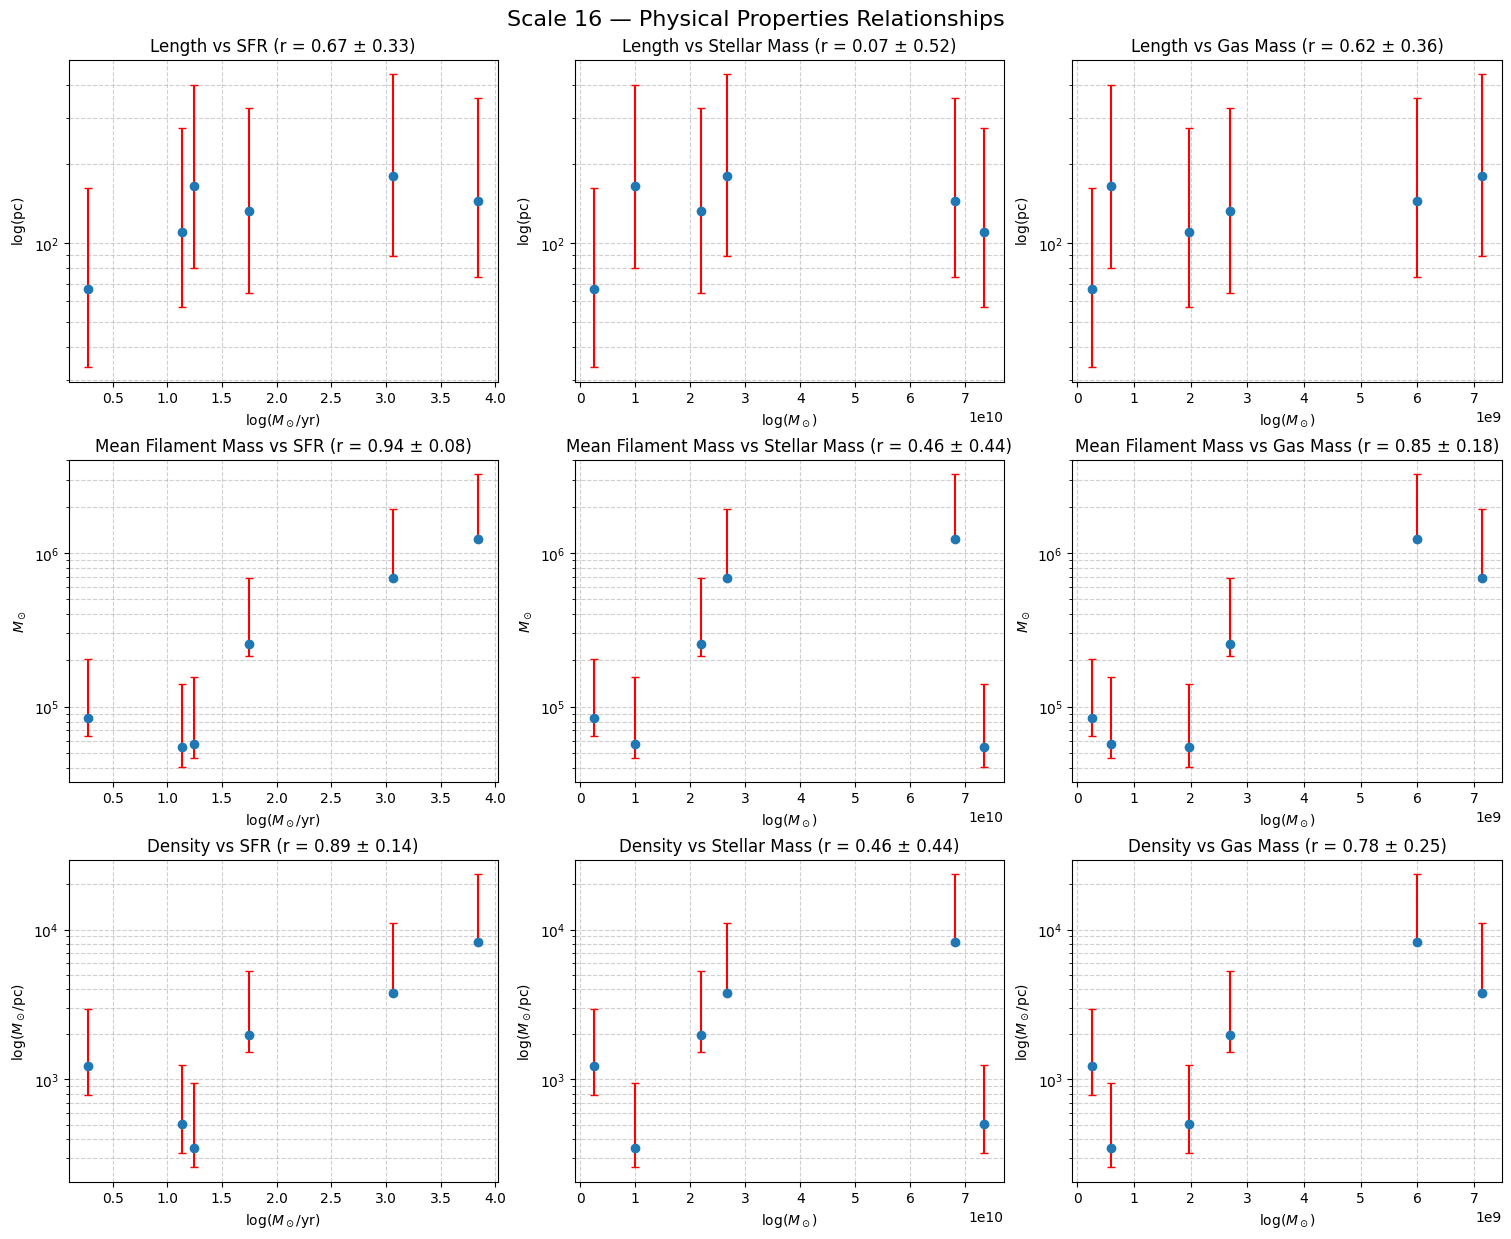

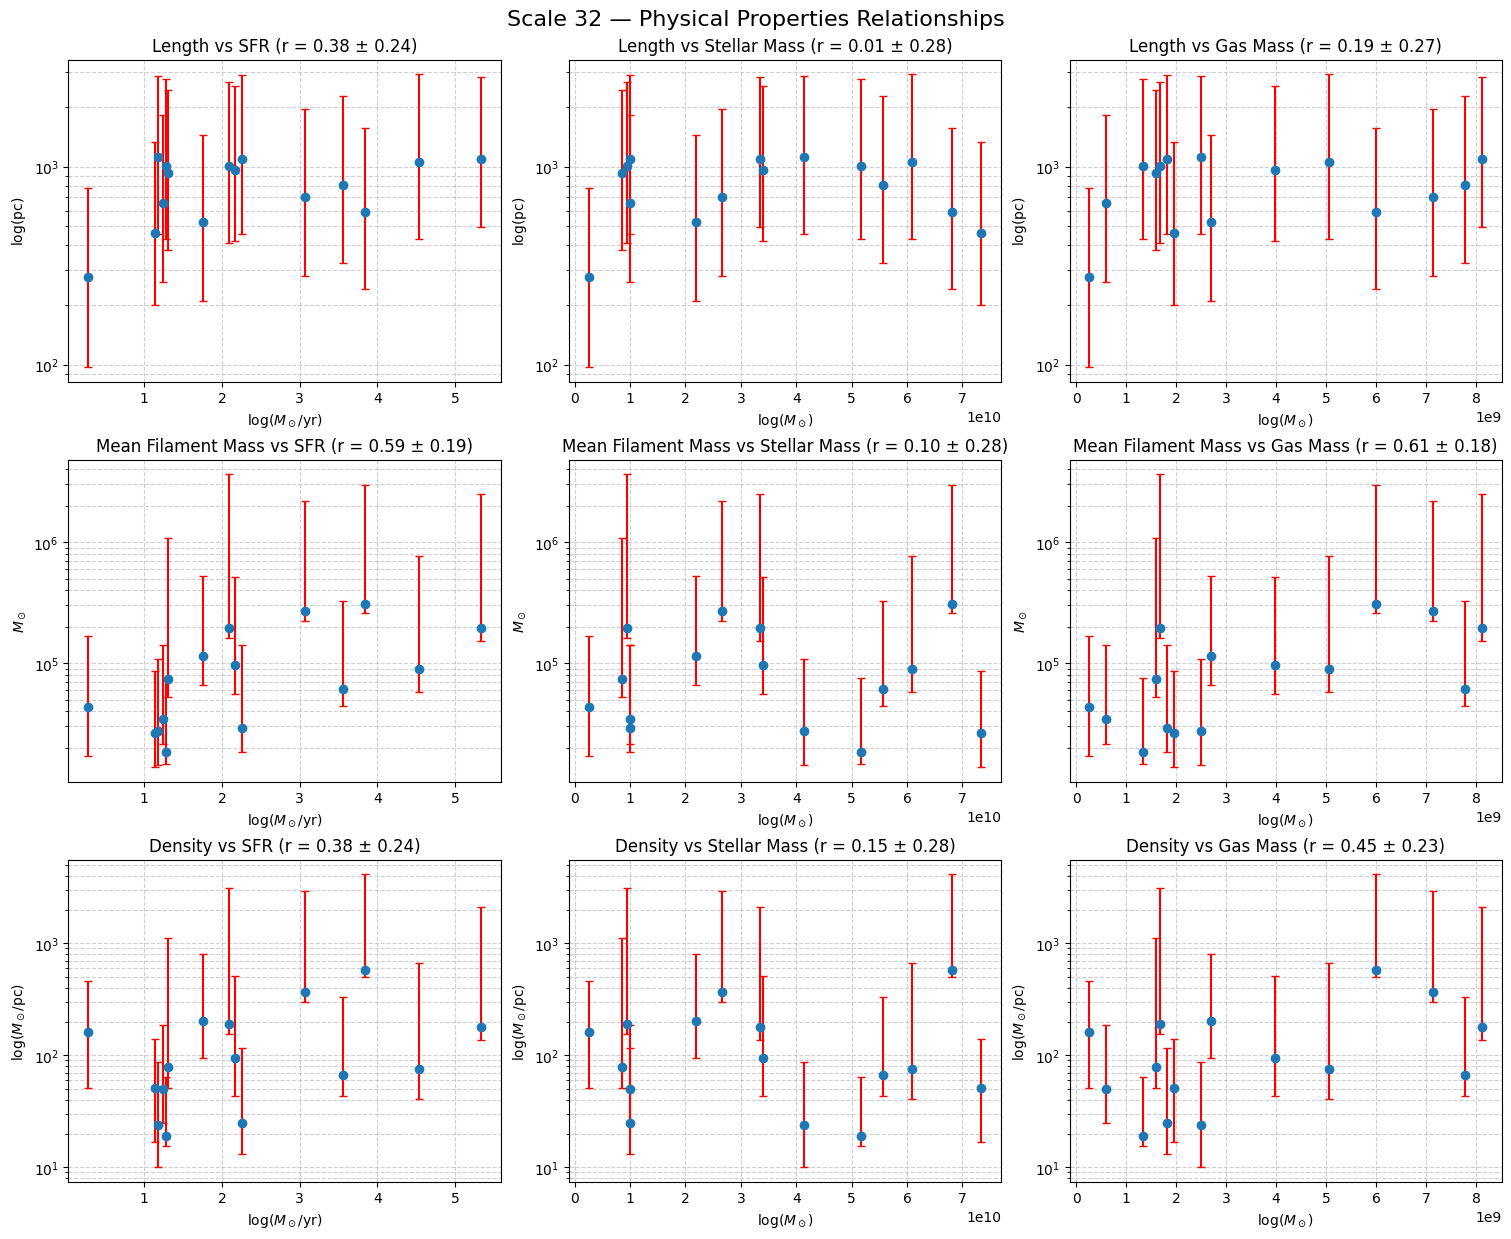

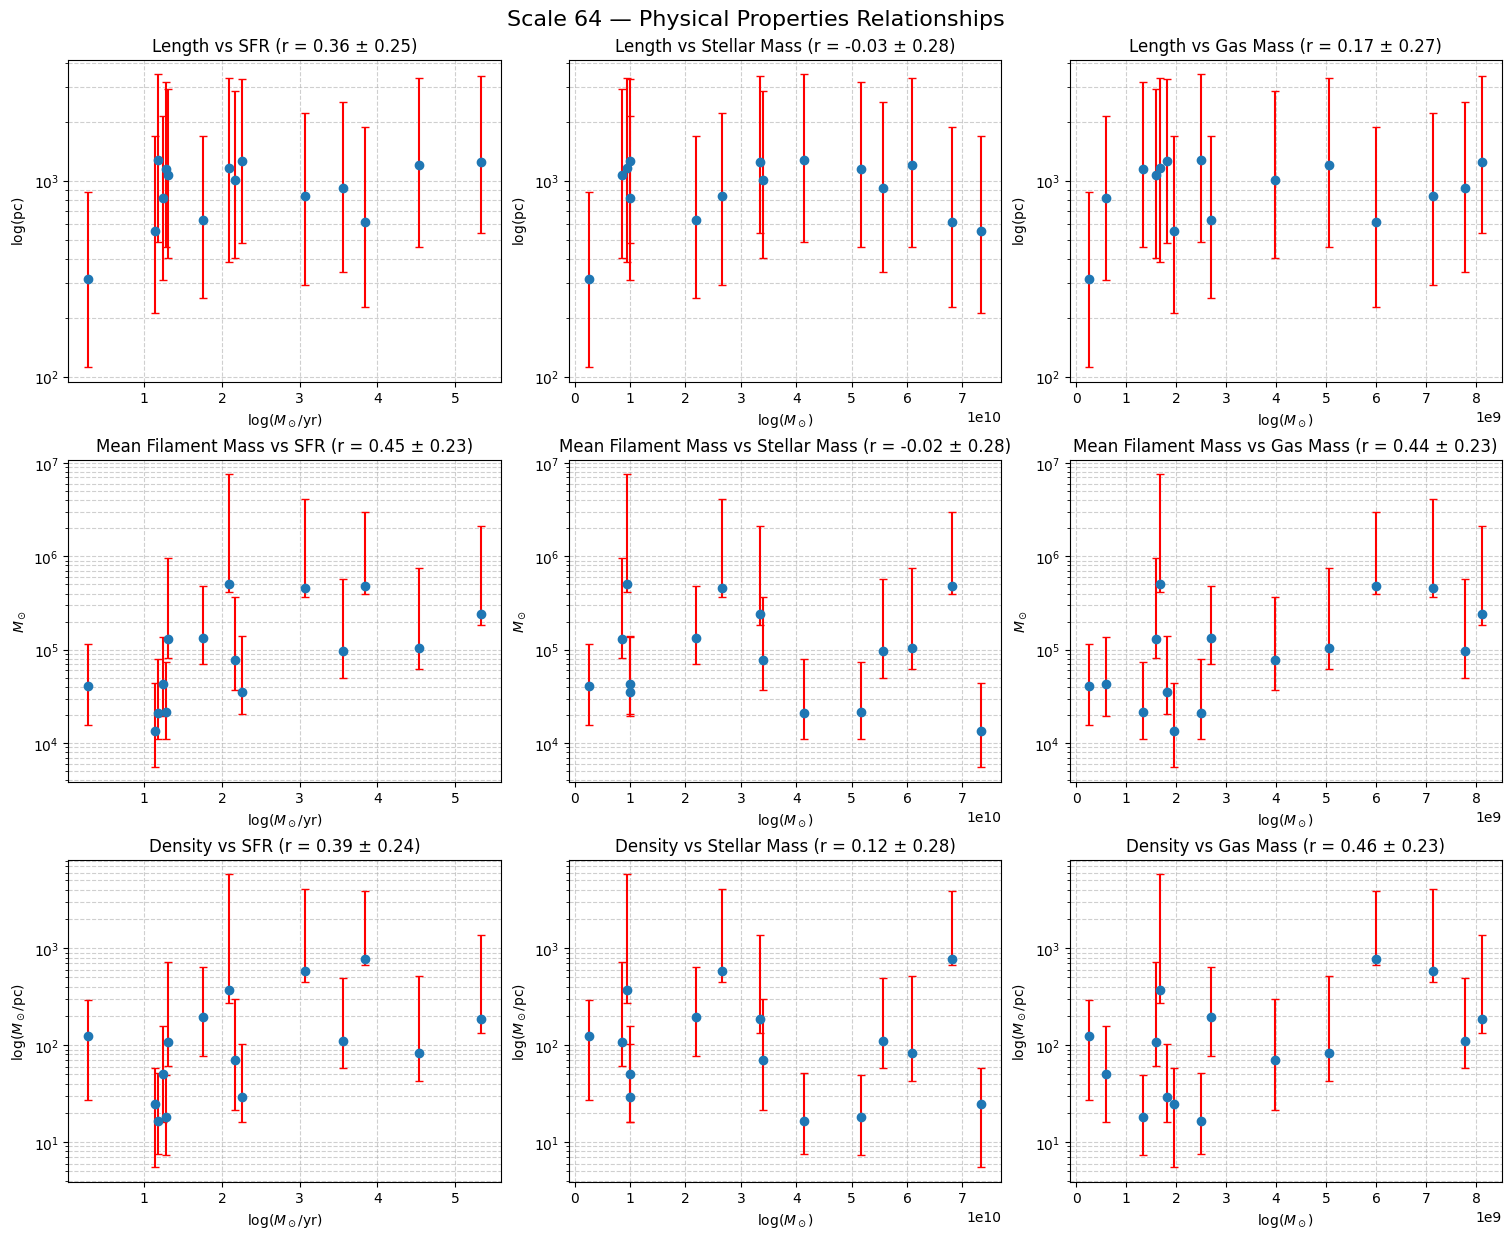

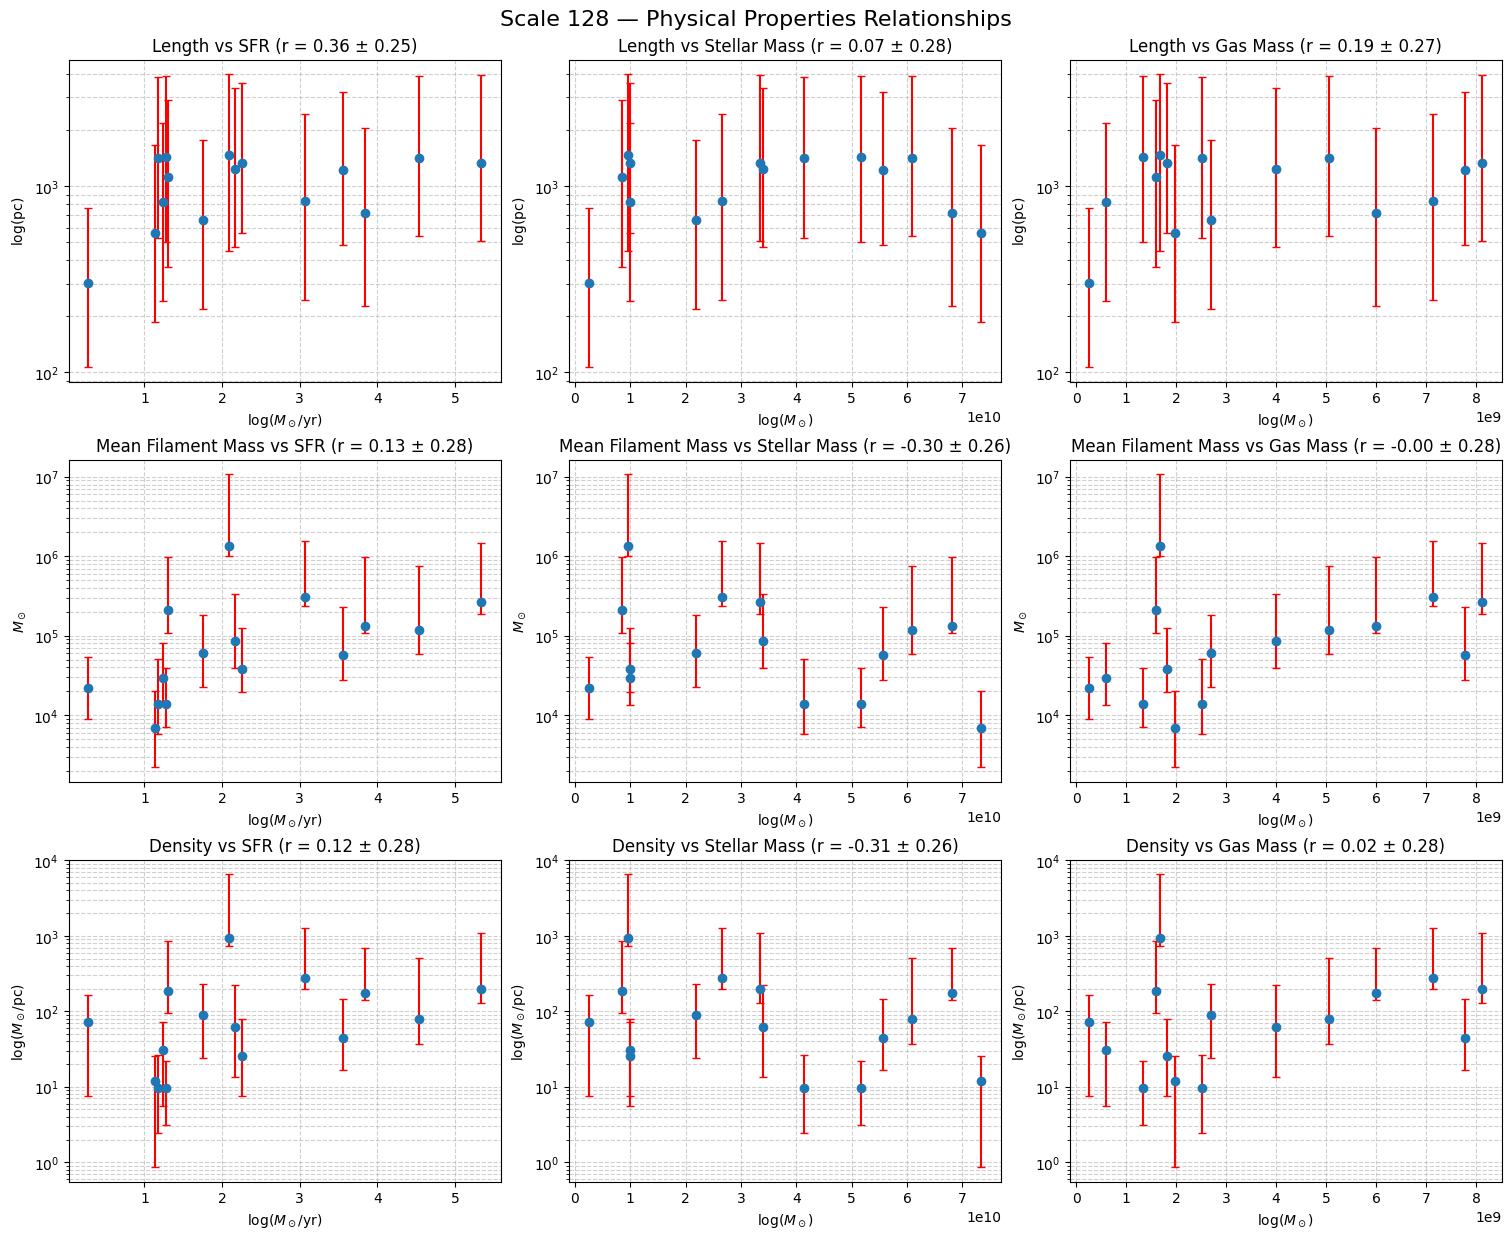

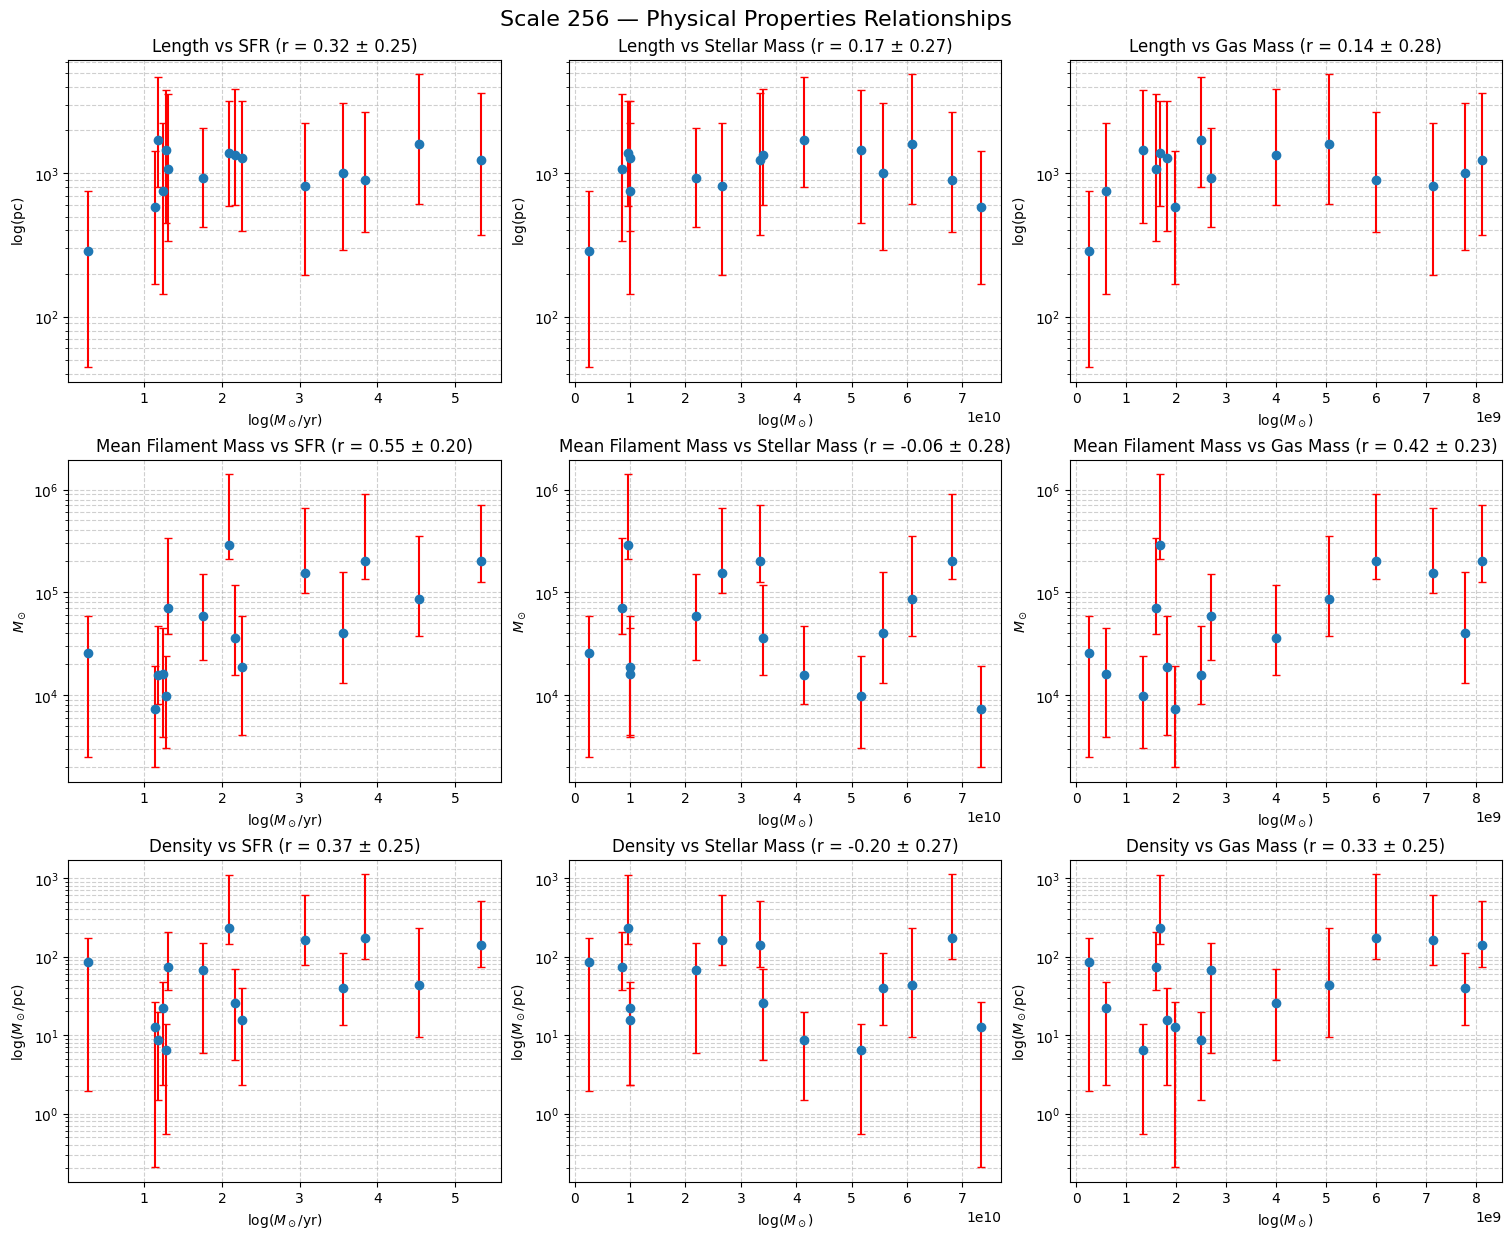

In [7]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import math
from astropy.table import Table

# Set consistent scale color mapping
scale_colors = {
    "8": "lightgreen",
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}

from scipy.stats import pearsonr

def corr_with_uncertainty(x, y):
    # Filter NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = len(x)
    if n < 4:
        return np.nan, np.nan  # too few points
    r, _ = pearsonr(x, y)
    # Fisher Z transform for uncertainty
    z = np.arctanh(r)
    sigma_z = 1.0 / np.sqrt(n - 3)
    r_low = np.tanh(z - sigma_z)
    r_high = np.tanh(z + sigma_z)
    r_err = (r_high - r_low) / 2.0
    return r, r_err


master_dict_16 = {}
master_dict_32 = {}
master_dict_64 = {}
master_dict_128 = {}
master_dict_256 = {}


def getProps(galaxy_name):
    galaxy_name  = galaxy_name.split('_')[0]
    print(galaxy_name)
    # Load the FITS file
    path = r"C:\Users\jhoffm72\Downloads\phangs_sample_table_v1p6.fits"
    with fits.open(path) as hdul:
        data = Table(hdul[1].data)
    name_col = 'name'
    mass_col = 'props_mstar'
    sfr_col = 'props_sfr'
    gas_col = 'mh2_phangs'
    row = data[data[name_col] == galaxy_name]
    if len(row) == 0:
        print("-" * 40)
    print(f" Stellar Mass ({mass_col}): {row[mass_col][0]:.2f} log(M☉)")
    print(f" SFR ({sfr_col}): {row[sfr_col][0]:.2f} log(M☉/yr)")
    print(f" Gas Mass ({gas_col}): {row[gas_col][0]:.2f} log(M☉)")
    print("-" * 40)
    return row[sfr_col][0], row[mass_col][0], row[gas_col][0]

def getScale(file):
    scales = ["256", "128", "64", "32", "16", "8"]
    for scale in scales:
        if f"_{scale}" in file or f"{scale}pc" in file:
            return scale
    return None

def plot_quantity(data_dict, quantity_type, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        data = np.array(data_dict[scale])
        log_data = np.log10(data[data > 0])
        color = scale_colors.get(scale, None)
        sns.kdeplot(log_data, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    ax.set_xlabel({
        "length": "log(pc)",
        "mass": "log(M☉)",
        "density": "log(M☉/pc)"
    }[quantity_type])
    ax.set_ylabel("Density")
    ax.set_title(quantity_type.capitalize())
    ax.grid(True, which="both", ls="--")

def plot_aspect_ratio(data_dict, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        ratio = data_dict[scale]
        log_ratio = np.log10(ratio[ratio > 0])
        color = scale_colors.get(scale, None)
        sns.kdeplot(log_ratio, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    ax.set_xlabel("log(Length / Scale)")
    ax.set_ylabel("Density")
    ax.set_title("Aspect Ratio")
    ax.grid(True, which="both", ls="--")

def plot_galaxy_image(fits_folder, galaxy_name, ax):
    try:
        for file in os.listdir(fits_folder):
            if file.endswith(".fits") and galaxy_name.lower() in file.lower():
                fits_path = os.path.join(fits_folder, file)
                with fits.open(fits_path) as hdul:
                    image_data = hdul[0].data
                    if image_data is not None:
                        image = np.nan_to_num(image_data)

                        # Pad image to square
                        y, x = image.shape
                        size = max(x, y)
                        pad_x = (size - x) // 2
                        pad_y = (size - y) // 2
                        image = np.pad(image, ((pad_y, size - y - pad_y), (pad_x, size - x - pad_x)), 
                                       mode='constant', constant_values=0)

                        vmin, vmax = np.percentile(image, [1, 99])
                        ax.imshow(image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
                        ax.set_title(galaxy_name, fontsize=12)
                        ax.axis('off')
                        return
        ax.set_title(f"{galaxy_name} (Image Not Found)", fontsize=10)
        ax.axis('off')
    except Exception:
        ax.set_title(f"{galaxy_name} (Error)", fontsize=10)
        ax.axis('off')

# Base paths
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
fits_folder = base_dir / "OriginalImages"
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)

# Filter valid galaxy folders
galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder)
    and folder not in ['Figures', 'OriginalImages']
    and not folder.endswith('.txt') and not folder.endswith('.xlsx')
]

# Load data for valid galaxies
valid_galaxies = []
galaxy_data = {}

for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'

    mass_dict = {}
    length_dict = {}
    density_dict = {}
    aspect_ratio_dict = {}

    for file in os.listdir(synthetic_folder):
        if not file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            if file.endswith(".xlsx"):
                df = pd.read_excel(file_path, engine='openpyxl')
            elif file.endswith(".xls"):
                df = pd.read_excel(file_path)
            elif file.endswith(".csv"):
                df = pd.read_csv(file_path)
            else:
                continue

            scale = getScale(file_path)
            if scale is None:
                continue

            try:
                mass = df[f'Mass_{scale}']
                if scale != "16":
                    Line_Density = df[f'Line_Density_{scale}'] / math.log2(int(scale))
                    lengths = df[f'Length_{scale}'] * math.log2(int(scale))
                else:
                    Line_Density = df[f'Line_Density_{scale}']
                    lengths = df[f'Length_{scale}']

                mass_dict[scale] = np.array(mass)
                length_dict[scale] = np.array(lengths)
                density_dict[scale] = np.array(Line_Density)
                aspect_ratio_dict[scale] = np.array(lengths) / float(scale)

                 # Lengths clipped to 16th–84th percentile
                lengthsd = lengths[(lengths >= np.percentile(lengths, 3)) & (lengths <= np.percentile(lengths, 97))]

                # Mass clipped
                mass = mass[(mass >= np.percentile(mass, 3)) & (mass <= np.percentile(mass, 97))]

                # Line density clipped
                Line_Density = Line_Density[(Line_Density >= np.percentile(Line_Density, 3)) & (Line_Density <= np.percentile(Line_Density, 97))]


                if scale == "16":
                    SFR, stellar_mass, gas_mass = getProps(galaxy_name)
                    master_dict_16[galaxy_name] = ((np.mean(lengths), np.percentile(lengths, 16), np.percentile(lengths, 84) ), (np.mean(mass), np.percentile(mass, 16), np.percentile(mass, 84)), (np.mean(Line_Density), np.percentile(Line_Density, 16), np.percentile(Line_Density, 84)), SFR, stellar_mass, gas_mass )

                elif scale == "32":
                    SFR, stellar_mass, gas_mass = getProps(galaxy_name)
                    master_dict_32[galaxy_name] = ((np.median(lengths), np.percentile(lengths, 16), np.percentile(lengths, 84) ), (np.median(mass), np.percentile(mass, 16), np.percentile(mass, 84)), (np.median(Line_Density), np.percentile(Line_Density, 16), np.percentile(Line_Density, 84)), SFR, stellar_mass, gas_mass )
               
                elif scale == "64": 
                    SFR, stellar_mass, gas_mass = getProps(galaxy_name)
                    master_dict_64[galaxy_name] = ((np.median(lengths), np.percentile(lengths, 16), np.percentile(lengths, 84) ), (np.median(mass), np.percentile(mass, 16), np.percentile(mass, 84)), (np.median(Line_Density), np.percentile(Line_Density, 16), np.percentile(Line_Density, 84)), SFR, stellar_mass, gas_mass )
               
                elif scale == "128": 
                    SFR, stellar_mass, gas_mass = getProps(galaxy_name)
                    master_dict_128[galaxy_name] = ((np.median(lengths), np.percentile(lengths, 16), np.percentile(lengths, 84) ), (np.median(mass), np.percentile(mass, 16), np.percentile(mass, 84)), (np.median(Line_Density), np.percentile(Line_Density, 16), np.percentile(Line_Density, 84)), SFR, stellar_mass, gas_mass )
                
                elif scale == "256":
                    SFR, stellar_mass, gas_mass = getProps(galaxy_name)
                    master_dict_256[galaxy_name] = ((np.median(lengths), np.percentile(lengths, 16), np.percentile(lengths, 84) ), (np.median(mass), np.percentile(mass, 16), np.percentile(mass, 84)), (np.median(Line_Density), np.percentile(Line_Density, 16), np.percentile(Line_Density, 84)), SFR, stellar_mass, gas_mass )

            except (KeyError, ValueError):
                continue

    if length_dict:
        valid_galaxies.append(galaxy_name)
        galaxy_data[galaxy_name] = {
            "mass": mass_dict,
            "length": length_dict,
            "density": density_dict,
            "aspect": aspect_ratio_dict
        }

# Function to plot subset of galaxies and save figure
def plot_galaxies_subset(galaxy_subset, filename):
    num = len(galaxy_subset)
    fig = plt.figure(figsize=(25, 4.8 * num))
    gs = gridspec.GridSpec(num, 5, figure=fig)

    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]
        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])
        ax3 = fig.add_subplot(gs[i, 2])
        ax4 = fig.add_subplot(gs[i, 3])
        ax5 = fig.add_subplot(gs[i, 4])

        plot_quantity(data["length"], "length", ax1)
        plot_quantity(data["mass"], "mass", ax2)
        plot_quantity(data["density"], "density", ax3)
        plot_aspect_ratio(data["aspect"], ax4)
        plot_galaxy_image(fits_folder, galaxy, ax5)

        ax1.set_ylabel("Density")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=color, lw=3)
        for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
    ]
    fig.legend(handles=legend_elements,
               labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
               loc='upper center', bbox_to_anchor=(0.5, 1.005),
               ncol=len(scale_colors), fontsize=12, frameon=False)

    plt.subplots_adjust(top=0.98, hspace=0.35)

    output_path = output_folder / filename
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    fig.savefig(output_folder / (filename.replace('.png', '.pdf')), format='pdf', bbox_inches='tight')
    plt.close(fig)

# Save all galaxies figure
plot_galaxies_subset(valid_galaxies, "AllGalaxies_Summary.png")


import matplotlib.pyplot as plt
import numpy as np

# Dictionary mapping scale to corresponding master_dict
all_dicts = {
    16: master_dict_16,
    32: master_dict_32,
    64: master_dict_64,
    128: master_dict_128,
    256: master_dict_256
}

# Axis labels with LaTeX units
y_labels = {
    'Length': r'$\log(\mathrm{pc})$',
    'Mean Filament Mass': r'$M_\odot$',
    'Density': r'$\log(M_\odot/\mathrm{pc})$'
}
x_labels = {
    'SFR': r'$\log(M_\odot/\mathrm{yr})$',
    'Stellar Mass': r'$\log(M_\odot)$',
    'Gas Mass': r'$\log(M_\odot)$'
}

# Loop through each scale and process the data + plot
for scale, master_dict in all_dicts.items():
    # Prepare data containers
    y_length = []
    y_length_error_min = []
    y_length_error_max = []
    y_mass = []
    y_mass_error_min = []
    y_mass_error_max = []
    y_density = []
    y_density_error_min = []
    y_density_error_max = []
    SFR = []
    stellar_mass = []
    gas_mass = []

    for k, v in master_dict.items():
        y_length.append(v[0][0])
        y_length_error_min.append(np.abs(v[0][1]))  # already symmetric
        y_length_error_max.append(np.abs(v[0][2]))  # already symmetric
        y_mass.append(v[1][0])
        y_mass_error_min.append(np.abs(v[1][1]))
        y_mass_error_max.append(np.abs(v[1][2]))
        y_density.append(v[2][0])
        y_density_error_min.append(np.abs(v[2][1]))
        y_density_error_max.append(np.abs(v[2][2]))
        SFR.append(v[3])
        stellar_mass.append(v[4])
        gas_mass.append(v[5])

    # Convert to numpy arrays
    y_data_all = {
        'Length': (np.array(y_length), np.array(list(zip(y_length_error_min, y_length_error_max)))),
        'Mean Filament Mass': (np.array(y_mass), np.array(list(zip(y_mass_error_min, y_mass_error_max)))),
        'Density': (np.array(y_density), np.array(list(zip(y_density_error_min, y_density_error_max))))
    }
    x_data_all = {
        'SFR': np.array(SFR),
        'Stellar Mass': np.array(stellar_mass),
        'Gas Mass': np.array(gas_mass)
    }


    # Plot configuration: 3 rows (y types), 3 cols (x types)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), constrained_layout=True)

    for i, (y_key, (y_vals, y_err)) in enumerate(y_data_all.items()):
        for j, (x_key, x_vals) in enumerate(x_data_all.items()):
            ax = axes[i, j]

            # Error bar plot
            ax.errorbar(
                x_vals, y_vals, y_err.T,
                fmt='o', ecolor='red', capsize=3
            )

            # Compute correlation with uncertainty
            r, r_err = corr_with_uncertainty(x_vals, y_vals)
            if not np.isnan(r):
                title_corr = f"(r = {r:.2f} ± {r_err:.2f})"
            else:
                title_corr = "(r = N/A)"

            ax.set_xlabel(x_labels[x_key])
            ax.set_ylabel(y_labels[y_key])
            ax.set_yscale('log')
            ax.grid(True, which='both', linestyle='--', alpha=0.6)
            ax.set_title(f'{y_key} vs {x_key} {title_corr}')


    # Save figure
    plt.suptitle(f"Scale {scale} — Physical Properties Relationships", fontsize=16, y=1.02)
    plt.savefig(f"scale_{scale}_length_mass_density_vs_sfr_stellargas.png", dpi=300, bbox_inches='tight')
    plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

ngc1087_F770W
ngc1300_F770W
ngc1385_F770W
ngc1433_F770W
ngc1512_F770W
ngc1566_F770W
ngc2835_F770W
ngc3627_F770W
ngc4254_F770W
ngc4303_F770W
ngc4321_F770W
ngc4535_F770W
ngc5068_F770W
ngc7496_F770W


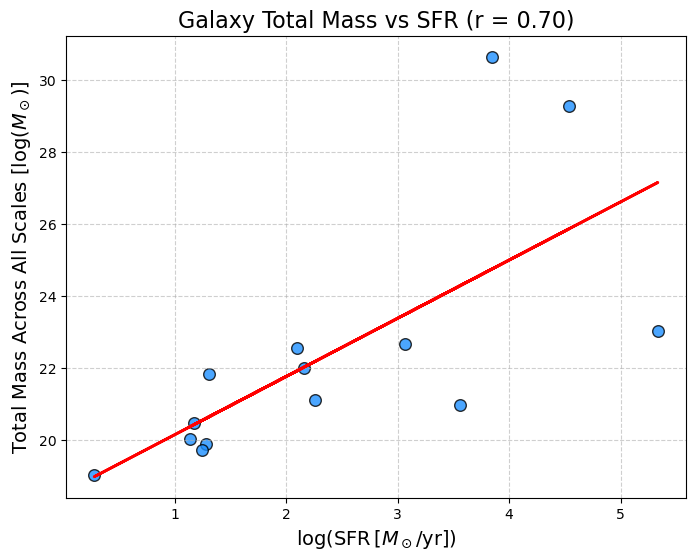

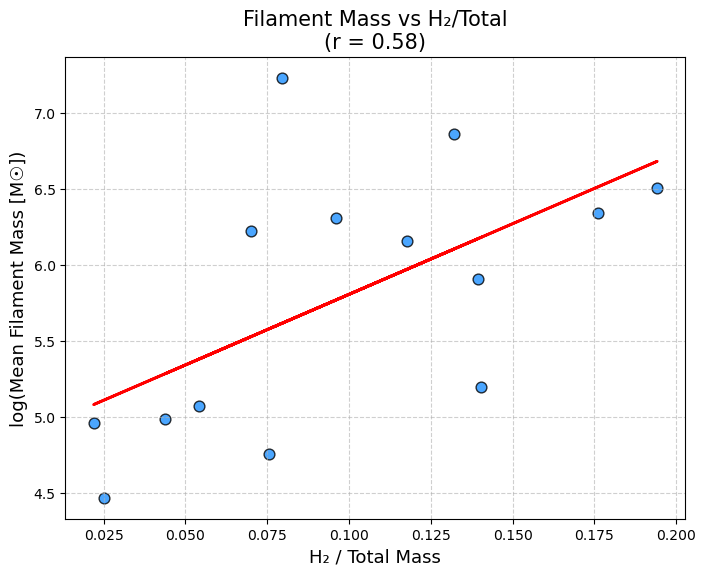

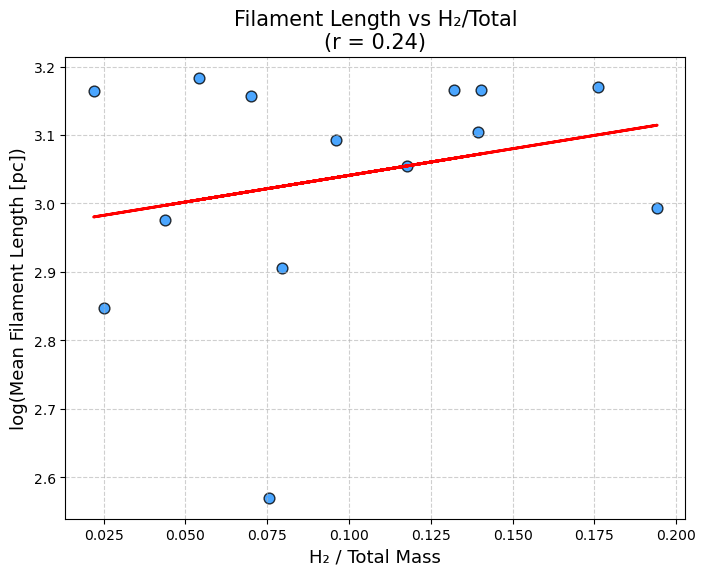

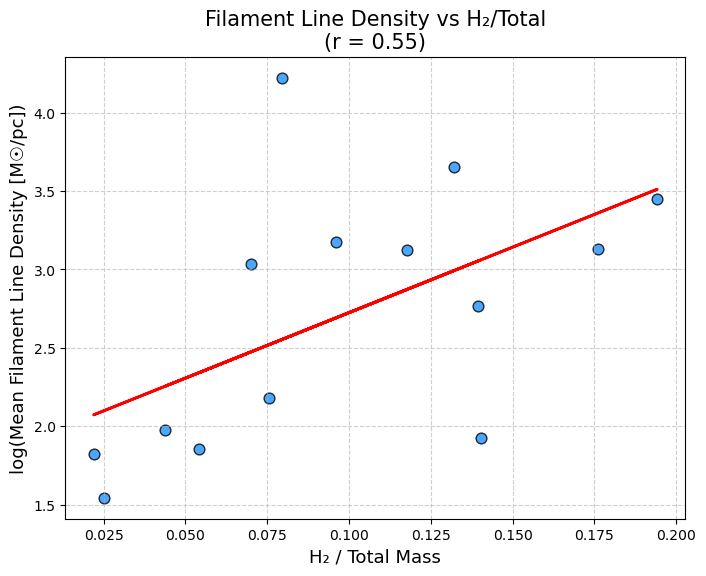

In [18]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table
import math
from scipy.stats import pearsonr

# -------------------------------
# Configuration
# -------------------------------
scale_colors = {
    "8": "lightgreen",
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}

def corr_with_uncertainty(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = len(x)
    if n < 4:
        return np.nan, np.nan
    r, _ = pearsonr(x, y)
    z = np.arctanh(r)
    sigma_z = 1.0 / np.sqrt(n - 3)
    r_low = np.tanh(z - sigma_z)
    r_high = np.tanh(z + sigma_z)
    r_err = (r_high - r_low) / 2.0
    return r, r_err

# -------------------------------
# Master dictionaries
# -------------------------------
master_dict_16, master_dict_32, master_dict_64, master_dict_128, master_dict_256 = {}, {}, {}, {}, {}

# -------------------------------
# Functions
# -------------------------------
def getProps(galaxy_name):
    galaxy_name = galaxy_name.split('_')[0]
    path = r"C:\Users\jhoffm72\Downloads\phangs_sample_table_v1p6.fits"
    with fits.open(path) as hdul:
        data = Table(hdul[1].data)
    row = data[data['name'] == galaxy_name]
    if len(row) == 0:
        return np.nan, np.nan, np.nan
    SFR = row['props_sfr'][0]
    stellar_mass = row['props_mstar'][0]
    gas_mass = row['mh2_phangs'][0]
    return SFR, stellar_mass, gas_mass

def getScale(file):
    for scale in ["256","128","64","32","16","8"]:
        if f"_{scale}" in file or f"{scale}pc" in file:
            return scale
    return None

def plot_quantity(data_dict, quantity_type, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        data = np.array(data_dict[scale])
        log_data = np.log10(data[data > 0])
        color = scale_colors.get(scale, None)
        sns.kdeplot(log_data, label=f"{scale} pc", linewidth=2, color=color, ax=ax)
    ax.set_xlabel({
        "length": "log(pc)",
        "mass": "log(M☉)",
        "density": "log(M☉/pc)"
    }[quantity_type])
    ax.set_ylabel("Density")
    ax.set_title(quantity_type.capitalize())
    ax.grid(True, which="both", ls="--")

def plot_aspect_ratio(data_dict, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        ratio = data_dict[scale]
        log_ratio = np.log10(ratio[ratio > 0])
        color = scale_colors.get(scale, None)
        sns.kdeplot(log_ratio, label=f"{scale} pc", linewidth=2, color=color, ax=ax)
    ax.set_xlabel("log(Length / Scale)")
    ax.set_ylabel("Density")
    ax.set_title("Aspect Ratio")
    ax.grid(True, which="both", ls="--")

def plot_galaxy_image(fits_folder, galaxy_name, ax):
    try:
        for file in os.listdir(fits_folder):
            if file.endswith(".fits") and galaxy_name.lower() in file.lower():
                with fits.open(os.path.join(fits_folder, file)) as hdul:
                    image_data = np.nan_to_num(hdul[0].data)
                    y, x = image_data.shape
                    size = max(x, y)
                    pad_x = (size - x)//2
                    pad_y = (size - y)//2
                    image_data = np.pad(image_data, ((pad_y, size - y - pad_y),(pad_x, size - x - pad_x)), mode='constant')
                    vmin, vmax = np.percentile(image_data, [1,99])
                    ax.imshow(image_data, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
                    ax.set_title(galaxy_name, fontsize=12)
                    ax.axis('off')
                    return
        ax.set_title(f"{galaxy_name} (Image Not Found)", fontsize=10)
        ax.axis('off')
    except Exception:
        ax.set_title(f"{galaxy_name} (Error)", fontsize=10)
        ax.axis('off')

# -------------------------------
# Paths
# -------------------------------
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
fits_folder = base_dir / "OriginalImages"
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)

# -------------------------------
# Collect galaxy data
# -------------------------------
galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder) and folder not in ['Figures', 'OriginalImages']
]

valid_galaxies = []
galaxy_data = {}

for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'
    mass_dict, length_dict, density_dict, aspect_dict = {}, {}, {}, {}
    for file in os.listdir(synthetic_folder):
        file_path = os.path.join(synthetic_folder, file)
        if not file.endswith(".fits") and file.endswith((".csv",".xlsx",".xls")):
            if file.endswith(".xlsx"):
                df = pd.read_excel(file_path, engine='openpyxl')
            elif file.endswith(".xls"):
                df = pd.read_excel(file_path)
            else:
                df = pd.read_csv(file_path)
            scale = getScale(file_path)
            if scale is None: continue
            try:
                mass = df[f'Mass_{scale}']
                if scale != "16":
                    Line_Density = df[f'Line_Density_{scale}']/math.log2(int(scale))
                    lengths = df[f'Length_{scale}']*math.log2(int(scale))
                else:
                    Line_Density = df[f'Line_Density_{scale}']
                    lengths = df[f'Length_{scale}']

                mass_dict[scale] = np.array(mass)
                length_dict[scale] = np.array(lengths)
                density_dict[scale] = np.array(Line_Density)
                aspect_dict[scale] = np.array(lengths)/float(scale)

                # Store master dict info
                SFR, stellar_mass, gas_mass = getProps(galaxy_name)
                target_dict = {"16":master_dict_16, "32":master_dict_32, "64":master_dict_64, "128":master_dict_128, "256":master_dict_256}[scale]
                target_dict[galaxy_name] = ((np.mean(lengths), np.percentile(lengths,16), np.percentile(lengths,84)),
                                            (np.mean(mass), np.percentile(mass,16), np.percentile(mass,84)),
                                            (np.mean(Line_Density), np.percentile(Line_Density,16), np.percentile(Line_Density,84)),
                                            SFR, stellar_mass, gas_mass)

            except (KeyError, ValueError):
                continue

    if mass_dict:
        valid_galaxies.append(galaxy_name)
        galaxy_data[galaxy_name] = {
            "mass": mass_dict,
            "length": length_dict,
            "density": density_dict,
            "aspect": aspect_dict
        }

# -------------------------------
# Plot function for galaxy summary
# -------------------------------
def plot_galaxies_subset(galaxy_subset, filename):
    num = len(galaxy_subset)
    fig = plt.figure(figsize=(25, 4.8*num))
    gs = gridspec.GridSpec(num, 5, figure=fig)
    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]
        ax1 = fig.add_subplot(gs[i,0])
        ax2 = fig.add_subplot(gs[i,1])
        ax3 = fig.add_subplot(gs[i,2])
        ax4 = fig.add_subplot(gs[i,3])
        ax5 = fig.add_subplot(gs[i,4])
        plot_quantity(data["length"], "length", ax1)
        plot_quantity(data["mass"], "mass", ax2)
        plot_quantity(data["density"], "density", ax3)
        plot_aspect_ratio(data["aspect"], ax4)
        plot_galaxy_image(fits_folder, galaxy, ax5)
        ax1.set_ylabel("Density")
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0],[0],color=color,lw=3) for scale,color in sorted(scale_colors.items(),key=lambda x: float(x[0]))]
    fig.legend(handles=legend_elements,
               labels=[f"{scale} pc" for scale in sorted(scale_colors,key=float)],
               loc='upper center', bbox_to_anchor=(0.5,1.005), ncol=len(scale_colors), fontsize=12, frameon=False)
    plt.subplots_adjust(top=0.98, hspace=0.35)
    output_path = output_folder / filename
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    fig.savefig(output_folder / (filename.replace('.png','.pdf')), format='pdf', bbox_inches='tight')
    plt.close(fig)

plot_galaxies_subset(valid_galaxies, "AllGalaxies_Summary.png")

# -------------------------------
# Total Mass Across All Scales vs SFR
# -------------------------------
SFR_list = []
total_mass_list = []

for galaxy in valid_galaxies:
    print(galaxy)
    data = galaxy_data[galaxy]["mass"]
    total_mass = 0.0
    for scale, mass_array in data.items():
        total_mass += np.sum(mass_array[mass_array > 0])
    # Get SFR from any master_dict
    for scale_dict in [master_dict_16, master_dict_32, master_dict_64, master_dict_128, master_dict_256]:
        if galaxy in scale_dict:
            SFR = scale_dict[galaxy][3]
            break
    SFR_list.append(SFR)
    total_mass_list.append(total_mass)

# Prepare data
x = np.array(SFR_list)
y = np.log(total_mass_list)  # log-transform total mass

# Compute linear fit
slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept

# Compute Pearson correlation coefficient
r, _ = pearsonr(x, y)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='dodgerblue', s=70, edgecolor='k', alpha=0.8)
plt.plot(x, y_fit, color='red', linewidth=2)
plt.xlabel(r'$\log(\mathrm{SFR}\,[M_\odot/\mathrm{yr}])$', fontsize=14)
plt.ylabel(r'Total Mass Across All Scales [$\log(M_\odot)$]', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.title(f'Galaxy Total Mass vs SFR (r = {r:.2f})', fontsize=16)
plt.show()

# -------------------------------
# Filament properties vs H2 / Total Mass
# -------------------------------

ratios = []
avg_mass_list = []
avg_length_list = []
avg_density_list = []

for galaxy in valid_galaxies:
    # Grab filament properties from one scale (say 64 pc) or aggregate
    if galaxy in master_dict_64:
        (length_stats, mass_stats, density_stats, SFR, stellar_mass, h2_mass) = master_dict_64[galaxy]
        # Extract HI mass too
        path = r"C:\Users\jhoffm72\Downloads\phangs_sample_table_v1p6.fits"
        with fits.open(path) as hdul:
            data = Table(hdul[1].data)
        row = data[data['name'] == galaxy.split('_')[0]]
        hi_mass = row['props_mhi'][0] if len(row) > 0 else 0.0

        total_mass = stellar_mass + hi_mass + h2_mass
        if total_mass > 0:
            ratio = h2_mass / total_mass
            ratios.append(ratio)
            avg_mass_list.append(mass_stats[0])      # mean filament mass
            avg_length_list.append(length_stats[0])  # mean filament length
            avg_density_list.append(density_stats[0])# mean filament line density

# Helper plotting function
def scatter_with_fit(x, y, xlabel, ylabel, title):
    x = np.array(x)
    y = np.array(y)
    mask = (np.isfinite(x)) & (np.isfinite(y)) & (y > 0) & (x > 0)
    x, y = x[mask], y[mask]
    logy = np.log10(y)

    # Fit line in log-space
    slope, intercept = np.polyfit(x, logy, 1)
    y_fit = slope * x + intercept
    r, _ = pearsonr(x, logy)

    plt.figure(figsize=(8,6))
    plt.scatter(x, logy, s=60, color="dodgerblue", edgecolor="k", alpha=0.8)
    plt.plot(x, y_fit, color="red", lw=2)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.title(f"{title}\n(r = {r:.2f})", fontsize=15)
    plt.grid(ls="--", alpha=0.6)
    plt.show()

# Plot each relation
scatter_with_fit(ratios, avg_mass_list,
                 "H₂ / Total Mass",
                 "log(Mean Filament Mass [M☉])",
                 "Filament Mass vs H₂/Total")

scatter_with_fit(ratios, avg_length_list,
                 "H₂ / Total Mass",
                 "log(Mean Filament Length [pc])",
                 "Filament Length vs H₂/Total")

scatter_with_fit(ratios, avg_density_list,
                 "H₂ / Total Mass",
                 "log(Mean Filament Line Density [M☉/pc])",
                 "Filament Line Density vs H₂/Total")


C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0032pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0128pc.fits_DensityData.csv
C:\Users\jhoffm72\Documents\FilPHANGS\Data\ngc0628_F770W\SyntheticMap\ngc0628_F770W_JWST_Emission_starsub_CDDss0256pc.fits_DensityData.csv
16
Processing scale: 16
Mass OK
Line Density OK
Length OK
Curvature column found, dtype: object
Curvature sample values: ['0.6472611688293298 rad', '0.6680315894815805 rad', '0.7491577685217812 rad', '0.5686058794529163 rad', '0.6920565835155688 rad']
Extracted 3049 curvature values
Curvature range: 0.33

C:\Users\jhoffm72\AppData\Local\Temp\ipykernel_22616\675926018.py:427: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(SFR_array, np.log10(median_sd_array), 1)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


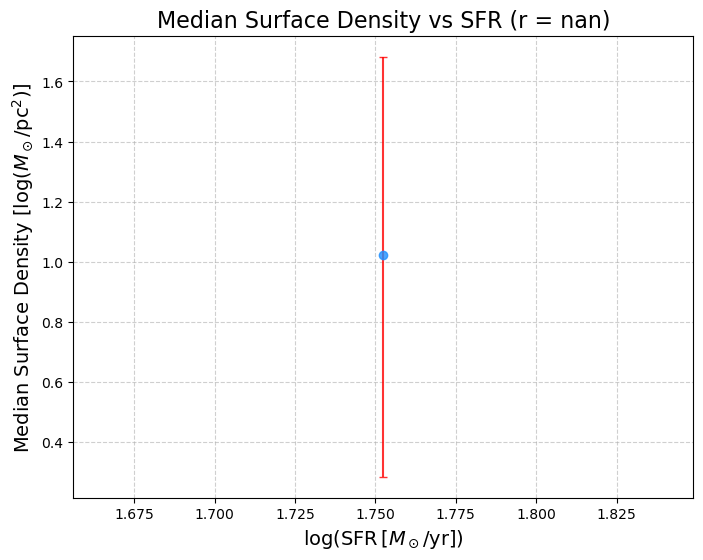

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import math

# Set consistent scale color mapping
scale_colors = {
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}


def get_min_scale(synthetic_folder):
    min_scale = 500
    for file in os.listdir(synthetic_folder):
        if not file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            print(file_path)
            scale = getScale(file_path)
            if int(scale) < int(min_scale):
                min_scale = scale
    return min_scale

def plot_aspect_ratio(data_dict, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        ratio = data_dict[scale]
        log_ratio = np.log10(ratio[ratio > 0])
        color = scale_colors.get(scale, None)
        sns.kdeplot(log_ratio, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    ax.set_xlabel("log(Length / Scale)")
    ax.set_ylabel("Density")
    ax.set_title("Aspect Ratio")
    ax.set_xlim(0, 2.5)

    ax.grid(True, which="both", ls="--")

def getScale(file):
    scales = ["256", "128", "64", "32", "16"]
    for scale in scales:
        if f"_{scale}" in file or f"{scale}pc" in file:
            return scale
    return None

def plot_quantity(data_dict, quantity_type, ax):
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        data = np.array(data_dict[scale])
        
        # Skip if no data
        if len(data) == 0:
            print(f"Warning: No data for {quantity_type} at scale {scale}")
            continue
            
        if quantity_type == "curvature":
            # For curvature, plot the actual values (not log)
            plot_data = data
        else:
            # For other quantities, plot log of positive values
            plot_data = np.log10(data[data > 0])
            
        color = scale_colors.get(scale, None)
        if len(plot_data) > 0:  # Only plot if we have data
            sns.kdeplot(plot_data, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    # Set x-axis labels and limits
    ax.set_xlabel({
        "length": "log(pc)",
        "mass": "log(M☉)",
        "density": "log(M☉/pc)",
        "aspect ratio": "log(AR)",
        "curvature": "Radians",
        "surface_density": "log(M☉/pc^2)"
    }[quantity_type])
    
    ax.set_ylabel("Density")
    ax.set_title(quantity_type.capitalize())
    ax.grid(True, which="both", ls="--")

    # Set appropriate x-axis limits
    xlims = {
        "length": (1, 5),
        "mass": (2, 8),
        "density": (0, 8),
        "curvature": (0, 2),  # More reasonable range for curvature
        "surface_density": (-3,5) 
        }
    if quantity_type in xlims:
        ax.set_xlim(xlims[quantity_type])

        
def plot_galaxy_image(fits_folder, galaxy_name, ax):
    try:
        for file in os.listdir(fits_folder):
            if file.endswith(".fits") and galaxy_name.lower() in file.lower():
                fits_path = os.path.join(fits_folder, file)
                with fits.open(fits_path) as hdul:
                    image_data = hdul[0].data
                    if image_data is not None:
                        image = np.nan_to_num(image_data)

                        # Pad image to square
                        y, x = image.shape
                        size = max(x, y)
                        pad_x = (size - x) // 2
                        pad_y = (size - y) // 2
                        image = np.pad(image, ((pad_y, size - y - pad_y), (pad_x, size - x - pad_x)), 
                                       mode='constant', constant_values=0)

                        vmin, vmax = (0,20) #(np.percentile(image, [1, 99]))
                        print(f'max: { vmax}')
                        ax.imshow(image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
                        ax.set_title(galaxy_name, fontsize=12)
                        ax.axis('off')
                        return
        ax.set_title(f"{galaxy_name} (Image Not Found)", fontsize=10)
        ax.axis('off')
    except Exception:
        ax.set_title(f"{galaxy_name} (Error)", fontsize=10)
        ax.axis('off')

# Base paths
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
fits_folder = base_dir / "OriginalImages"
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)

# Filter valid galaxy folders
galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder)
    and folder not in ['Figures', 'OriginalImages', 'IC5146_PSW']
    and not folder.endswith('.txt') and not folder.endswith('.xlsx')
]

# Load data for valid galaxies
valid_galaxies = []
galaxy_data = {}



for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'

    mass_dict = {}
    length_dict = {}
    density_dict = {}
    aspect_ratio_dict = {}
    curvature_dict = {}
    mass_surface = {}

    min_scale = get_min_scale(synthetic_folder)
    for file in os.listdir(synthetic_folder):
        if not file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            if file.endswith(".xlsx"):
                df = pd.read_excel(file_path, engine='openpyxl')
            elif file.endswith(".xls"):
                df = pd.read_excel(file_path)
            elif file.endswith(".csv"):
                df = pd.read_csv(file_path)
            else:
                continue

            scale = getScale(file_path)
            print(scale)
            if scale is None:
                continue

            try:
                print(f"Processing scale: {scale}")
                mass = df[f'Mass_{scale}.0']
                print("Mass OK")

                Line_Density = df[f'Line_Density_{scale}.0'] * (int(min_scale)/int(scale))
                print("Line Density OK")

                lengths = df[f'Length_{scale}.0'] * (int(scale)/int(min_scale))
                print("Length OK")

                mass_dict[scale] = np.array(mass)
                length_dict[scale] = np.array(lengths)
                density_dict[scale] = np.array(Line_Density)
                aspect_ratio_dict[scale] = np.array(lengths) / float(scale)
                
                # DEBUG: Check if curvature column exists
                curvature_col_name = f'Curvature_{scale}.0'
                if curvature_col_name not in df.columns:
                    print(f"ERROR: Column '{curvature_col_name}' not found in dataframe!")
                    print(f"Available columns: {[col for col in df.columns if scale in col]}")
                    continue
                
                curvature = df[curvature_col_name]
                print(f"Curvature column found, dtype: {curvature.dtype}")
                print(f"Curvature sample values: {curvature.head().tolist()}")
                
                # Handle different data types and missing values properly
                curvature_values = []
                for i, s in enumerate(curvature):
                    if pd.isna(s):
                        #print(f"NaN at index {i}")
                        continue
                    try:
                        # Handle if it's already a number
                        if isinstance(s, (int, float, np.number)):
                            curvature_values.append(float(s))
                        # Handle if it's a string with units (e.g., "1.23 rad")
                        elif isinstance(s, str):
                            # Extract numeric part before any space
                            numeric_part = s.split()[0]
                            curvature_values.append(float(numeric_part))
                        else:
                            print(f"Unexpected type at index {i}: {type(s)} - {s}")
                    except (ValueError, AttributeError) as e:
                        print(f"Error processing index {i}: {s} - {e}")
                        continue
                
                print(f"Extracted {len(curvature_values)} curvature values")
                if curvature_values:
                    print(f"Curvature range: {min(curvature_values):.3f} to {max(curvature_values):.3f}")
                
                curvature_dict[scale] = np.array(curvature_values)

            except (KeyError, ValueError) as e:
                print(f"ERROR!!! {type(e).__name__}: {e}")
                print(f"Error occurred at scale: {scale}")
                continue

            try:
                surface_density_path = base_dir / folder / 'Molecular_Mass'
                for fname in os.listdir(surface_density_path):
                    file = os.path.join(surface_density_path, fname)

                    # Skip non-FITS
                    if not file.lower().endswith(('.fits', '.fit', '.fz')) or not os.path.isfile(file):
                        print(f"Skipping: {file}")
                        continue

                    try:
                        scale = getScale(file)

                        with fits.open(file, ignore_missing=True) as hdul:
                            if hdul[0].data is None:
                                print(f"No data in primary HDU for {file}")
                                continue
                            OrigData = np.array(hdul[0].data)

                        surface_density_data = np.array(OrigData.flatten()) / (5.24**2)  # 1 px = 5.24 pc^2
                        surface_density_data = np.array(surface_density_data[surface_density_data != 0])

                        Npix = 1.13 * (16 / 5.24) ** 2 * int(scale) / 16
                        mass_surface[scale] = np.array(surface_density_data) / Npix

                        print(f"✅ {file} → median = {np.median(surface_density_data / Npix)}")

                    except Exception as e:
                        print(f"❌ Error processing {file}: {e}")
                        continue

            except Exception as e:
                print(f"❌ Could not find molecular mass data: {e}")

        file
    if length_dict:
        valid_galaxies.append(galaxy_name)
        galaxy_data[galaxy_name] = {
            "mass": mass_dict,
            "length": length_dict,
            "density": density_dict,
            "aspect": aspect_ratio_dict,
            "curvature": curvature_dict,
            "surface_density": mass_surface
        }

# Function to plot subset of galaxies and save figure
def plot_galaxies_subset(galaxy_subset, filename):
    num = len(galaxy_subset)
    fig = plt.figure(figsize=(25, 4.8 * num))
    gs = gridspec.GridSpec(num, 7, figure=fig)

    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]
        ax1 = fig.add_subplot(gs[i, 0])
        ax2 = fig.add_subplot(gs[i, 1])
        ax3 = fig.add_subplot(gs[i, 2])
        ax4 = fig.add_subplot(gs[i, 3])
        ax5 = fig.add_subplot(gs[i, 4])
        ax6 = fig.add_subplot(gs[i, 5])
        ax7 = fig.add_subplot(gs[i, 6])

        plot_quantity(data["length"], "length", ax1)
        plot_quantity(data["mass"], "mass", ax2)
        plot_quantity(data["density"], "density", ax3)
        plot_quantity(data["surface_density"], "surface_density", ax4)
        plot_aspect_ratio(data["aspect"], ax5)
        plot_quantity(data["curvature"], "curvature", ax6)
        plot_galaxy_image(fits_folder, galaxy, ax7)

        ax1.set_ylabel("Density")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=color, lw=3)
        for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
    ]
    fig.legend(handles=legend_elements,
               labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
               loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=len(scale_colors), fontsize=12, frameon=False)

    plt.subplots_adjust(top=0.98, hspace=0.35)

    output_path = output_folder / filename
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    fig.savefig(output_folder / (filename.replace('.png', '.pdf')), format='pdf', bbox_inches='tight')
    plt.show()

# Save all galaxies figure
# plot_galaxies_subset(valid_galaxies, "AllGalaxies_Summary.png")

# # Save first 9 galaxies figure
# plot_galaxies_subset(valid_galaxies[:9], "First9Galaxies_Summary.png")

# # Save last 9 galaxies figure
# plot_galaxies_subset(valid_galaxies[-9:], "Last9Galaxies_Summary.png")

# # Save first 9 galaxies figure



from collections import defaultdict
import numpy as np

# Define the scales and initialize the master dict
scales = ['8', "16", "32", "64", "128", "256"]
quantities = ["mass", "length", "density", "surface_density", "curvature", "aspect"]
master_dict = {q: {scale: [] for scale in scales} for q in quantities}

# Combine data across all galaxies
for galaxy in valid_galaxies:
    mass_data = galaxy_data[galaxy]["mass"]
    length_data = galaxy_data[galaxy]["length"]
    density_data = galaxy_data[galaxy]["density"]
    aspect_data = galaxy_data[galaxy]["aspect"]
    curvature_data = galaxy_data[galaxy]["curvature"]
    surface_density_data = galaxy_data[galaxy]["surface_density"]
    for scale in scales:
        try:
            master_dict["mass"][scale].append(mass_data[scale])
            master_dict["length"][scale].append(length_data[scale])
            master_dict["density"][scale].append(density_data[scale])
            master_dict["aspect"][scale].append(aspect_data[scale])
            master_dict["curvature"][scale].append(curvature_data[scale])
            master_dict["surface_density"][scale].append(surface_density_data[scale])

        except KeyError:
            # Skip if this galaxy doesn't have data for this scale
            continue

# Convert lists of arrays into flat numpy arrays
for quantity in master_dict:
    for scale in master_dict[quantity]:
        if master_dict[quantity][scale]:  # Avoid empty lists
            master_dict[quantity][scale] = np.concatenate(master_dict[quantity][scale])
        else:
            master_dict[quantity][scale] = np.array([])  # fallback for missing data



# Prepare containers
SFR_list = []
median_sd_list = []
lower_err = []
upper_err = []

for galaxy in valid_galaxies:
    # Get SFR from any master_dict (pick first available scale)
    for scale_dict in [master_dict_16, master_dict_32, master_dict_64, master_dict_128, master_dict_256]:
        if galaxy in scale_dict:
            SFR = scale_dict[galaxy][3]  # SFR
            break

    # Gather all surface density data across scales for this galaxy
    sd_data = []
    for scale, sd_array in galaxy_data[galaxy]["surface_density"].items():
        sd_data.append(sd_array[sd_array > 0])  # only positive values

    if not sd_data:
        continue

    sd_all = np.concatenate(sd_data)
    median_sd = np.median(sd_all)
    q16, q84 = np.percentile(sd_all, [16, 84])
    
    SFR_list.append(SFR)
    median_sd_list.append(median_sd)
    lower_err.append(median_sd - q16)
    upper_err.append(q84 - median_sd)

# Convert to arrays
SFR_array = np.array(SFR_list)
median_sd_array = np.array(median_sd_list)
yerr = np.array([lower_err, upper_err])

# Plot median surface density vs SFR with IQR error bars
plt.figure(figsize=(8,6))
plt.errorbar(SFR_array, np.log10(median_sd_array), yerr=[np.log10(median_sd_array)-np.log10(median_sd_array - lower_err),
                                                        np.log10(median_sd_array + upper_err)-np.log10(median_sd_array)],
             fmt='o', color='dodgerblue', ecolor='red', capsize=3, alpha=0.8)

plt.xlabel(r'$\log(\mathrm{SFR}\,[M_\odot/\mathrm{yr}])$', fontsize=14)
plt.ylabel(r'Median Surface Density [$\log(M_\odot/\mathrm{pc}^2)$]', fontsize=14)
plt.title('Median Surface Density vs SFR', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.6)

# Optional: add linear fit + r
slope, intercept = np.polyfit(SFR_array, np.log10(median_sd_array), 1)
y_fit = slope * SFR_array + intercept
r = np.corrcoef(SFR_array, np.log10(median_sd_array))[0,1]
plt.plot(SFR_array, y_fit, color='red', linewidth=2)
plt.title(f'Median Surface Density vs SFR (r = {r:.2f})', fontsize=16)

plt.show()


TypeError: expected non-empty vector for x